# Constrained Single Image Reconstruction



based on https://pytorch3d.org/tutorials/fit_textured_volume

## 0. Install and Import modules
Ensure `torch` and `torchvision` are installed. If `pytorch3d` is not installed, install it using the following cell:

In [1]:
from IPython.display import clear_output 
# !conda install -c conda-forge python-kaleido
# import locale
# locale.getpreferredencoding = lambda: "UTF-8"
# !pip install trimesh
# !pip install -U kaleido
# !pip3 install mesh-to-sdf

# !pip install trimesh

clear_output()

In [2]:
import os
import sys
import torch
# from IPython.display import clear_output 
# need_pytorch3d=False
# try:
#     import pytorch3d
# except ModuleNotFoundError:
#     need_pytorch3d=True
# if need_pytorch3d:
#     if torch.__version__.startswith(("1.13.", "2.0.")) and sys.platform.startswith("linux"):
#         # We try to install PyTorch3D via a released wheel.
#         pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
#         version_str="".join([
#             f"py3{sys.version_info.minor}_cu",
#             torch.version.cuda.replace(".",""),
#             f"_pyt{pyt_version_str}"
#         ])
#         !pip3 install fvcore iopath
#         !pip3 install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
#     else:
#         # We try to install PyTorch3D from source.
#         !pip3 install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'


# clear_output()

In [3]:
import os
import sys
import time
import json
import glob
import torch
import math
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from IPython import display

# Data structures and functions for rendering
from pytorch3d.structures import Volumes
from pytorch3d.renderer import (
    FoVPerspectiveCameras, 
    VolumeRenderer,
    NDCMultinomialRaysampler,
    EmissionAbsorptionRaymarcher
)
from pytorch3d.transforms import so3_exp_map

# obtain the utilized device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")



In [4]:
# @title FEA imports

# from IPython.display import clear_output 

# # !wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/generate_cow_renders.py
# # from plot_image_grid import image_grid
# # from generate_cow_renders import generate_cow_renders
# !wget -O constrained_ai.zip https://www.dropbox.com/sh/qkqnreiw6fjtxy0/AAA9N8oEp1tYFvYLf0_FMJ3Oa?dl=0
# !unzip -o -d constrained_ai constrained_ai.zip

# from constrained_ai.pytorch3DLibs.generate_obj_renders import generate_obj_renders
# from constrained_ai.pytorch3DLibs.plot_image_grid import image_grid

# clear_output()

# import os
# os.environ['PYOPENGL_PLATFORM'] = 'egl'
import numpy as np
import matplotlib.pyplot as plt

import numpy as np


from constrained_ai.pytorch3DLibs.generate_obj_renders import generate_obj_renders
from constrained_ai.pytorch3DLibs.plot_image_grid import image_grid

import kaleido
import trimesh
import skimage
# from mesh_to_sdf import mesh_to_voxels
clear_output()
import constrained_ai.examples 
import constrained_ai.Mesher 
import constrained_ai.material 
import constrained_ai.plotUtil 
import constrained_ai.FE_Solver

from constrained_ai.examples import getExampleBC3D
from constrained_ai.Mesher import RectangularGridMesher3D
from constrained_ai.material import Material
from constrained_ai.FE_Solver import FESolver
import configparser

import importlib
importlib.reload(constrained_ai.examples)
importlib.reload(constrained_ai.Mesher)
importlib.reload(constrained_ai.material)
importlib.reload(constrained_ai.plotUtil)
importlib.reload(constrained_ai.FE_Solver)
from constrained_ai.examples import getExampleBC3D
from constrained_ai.Mesher import RectangularGridMesher3D
from constrained_ai.material import Material
from constrained_ai.plotUtil import plotDisplacement , plotFieldOnMesh
from constrained_ai.FE_Solver import FESolver


## 1. Generate images of the scene and masks



The following cell generates the training data.
It renders the obj mesh from several viewpoints and returns:
1. A batch of image and silhouette tensors that are produced by the obj mesh renderer.
2. A set of cameras corresponding to each render.

In [6]:
target_cameras, target_images, target_silhouettes = generate_obj_renders(num_views=20,data_dir="./constrained_ai/data/",objName="t1")
# Experiment with Generate_object_renders t get top view and bottom view
print(f'Generated {len(target_images)} images/silhouettes/cameras.')

Generated 20 images/silhouettes/cameras.


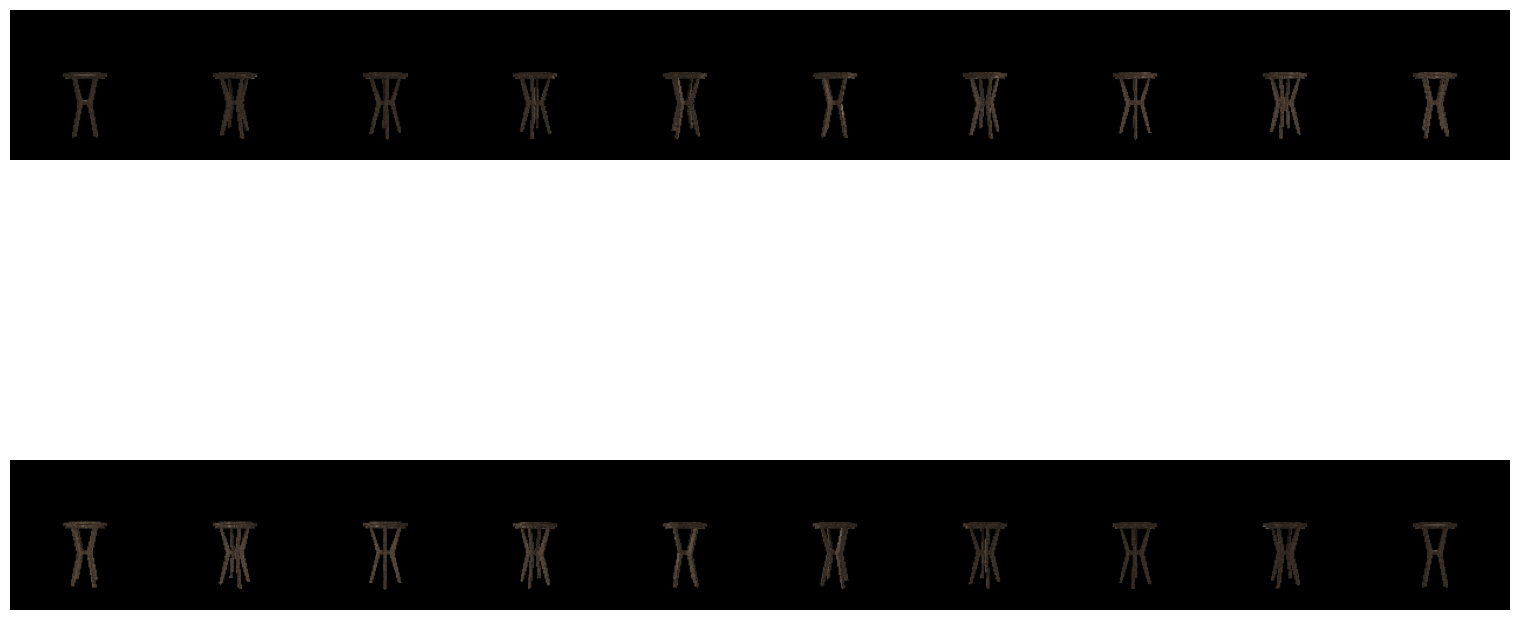

In [9]:
image_grid(target_images.clamp(0., 1.).cpu().numpy(), rows=2, cols=10, rgb=True, fill=True)
plt.show()

## 2. Initialize the volumetric renderer



The following initializes a volumetric renderer that emits a ray from each pixel of a target image and samples a set of uniformly-spaced points along the ray. At each ray-point, the corresponding density and color value is obtained by querying the corresponding location in the volumetric model of the scene (the model is described & instantiated in a later cell).

The renderer is composed of a *raymarcher* and a *raysampler*.
- The *raysampler* is responsible for emitting rays from image pixels and sampling the points along them. Here, we use the `NDCMultinomialRaysampler` which follows the standard PyTorch3D coordinate grid convention (+X from right to left; +Y from bottom to top; +Z away from the user).
- The *raymarcher* takes the densities and colors sampled along each ray and renders each ray into a color and an opacity value of the ray's source pixel. Here we use the `EmissionAbsorptionRaymarcher` which implements the standard Emission-Absorption raymarching algorithm.

In [12]:
# render_size describes the size of both sides of the 
# rendered images in pixels. We set this to the same size
# as the target images. I.e. we render at the same
# size as the ground truth images.
render_size = target_images.shape[1]

# Our rendered scene is centered around (0,0,0) 
# and is enclosed inside a bounding box
# whose side is roughly equal to 3.0 (world units).
volume_extent_world = 6

# 1) Instantiate the raysampler.
# Here, NDCMultinomialRaysampler generates a rectangular image
# grid of rays whose coordinates follow the PyTorch3D
# coordinate conventions.
# Since we use a volume of size 128^3, we sample n_pts_per_ray=150,
# which roughly corresponds to a one ray-point per voxel.
# We further set the min_depth=0.1 since there is no surface within
# 0.1 units of any camera plane.
raysampler = NDCMultinomialRaysampler(
    image_width=render_size,
    image_height=render_size,
    n_pts_per_ray=150,
    min_depth=0.1,
    max_depth=volume_extent_world,
)


# 2) Instantiate the raymarcher.
# Here, we use the standard EmissionAbsorptionRaymarcher 
# which marches along each ray in order to render
# each ray into a single 3D color vector 
# and an opacity scalar.
raymarcher = EmissionAbsorptionRaymarcher()

# Finally, instantiate the volumetric render
# with the raysampler and raymarcher objects.
renderer = VolumeRenderer(
    raysampler=raysampler, raymarcher=raymarcher,
)

## 3. Initialize the volumetric model



Next we instantiate a volumetric model of the scene. This quantizes the 3D space to cubical voxels, where each voxel is described with a 3D vector representing the voxel's RGB color and a density scalar which describes the opacity of the voxel (ranging between [0-1], the higher the more opaque).

In order to ensure the range of densities and colors is between [0-1], we represent both volume colors and densities in the logarithmic space. During the forward function of the model, the log-space values are passed through the sigmoid function to bring the log-space values to the correct range.

Additionally, `VolumeModel` contains the renderer object. This object stays unaltered throughout the optimization.

In this cell we also define the `huber` loss function which computes the discrepancy between the rendered colors and masks.

In [77]:
class VolumeModel(torch.nn.Module):
    def __init__(self, renderer, volume_size=[64] * 3, voxel_size=0.1):
        super().__init__()
        # After evaluating torch.sigmoid(self.log_colors), we get 
        # densities close to zero.
        self.log_densities = torch.nn.Parameter(-4.0 * torch.ones(1, *volume_size))
        # After evaluating torch.sigmoid(self.log_colors), we get 
        # a neutral gray color everywhere.
        self.log_colors = torch.nn.Parameter(torch.zeros(3, *volume_size))
        self._voxel_size = voxel_size
        # Store the renderer module as well.
        self._renderer = renderer
        
    def forward(self, cameras):
        batch_size = cameras.R.shape[0]

        # Convert the log-space values to the densities/colors
        densities = torch.sigmoid(self.log_densities)
        colors = torch.sigmoid(self.log_colors)
        
        # Instantiate the Volumes object, making sure
        # the densities and colors are correctly
        # expanded batch_size-times.
        volumes = Volumes(
            densities = densities[None].expand(
                batch_size, *self.log_densities.shape),
            features = colors[None].expand(
                batch_size, *self.log_colors.shape),
            voxel_size=self._voxel_size,
        )
        
        # Given cameras and volumes, run the renderer
        # and return only the first output value 
        # (the 2nd output is a representation of the sampled
        # rays which can be omitted for our purpose).
        return self._renderer(cameras=cameras, volumes=volumes)[0]
    
# A helper function for evaluating the smooth L1 (huber) loss
# between the rendered silhouettes and colors.
def huber(x, y, scaling=0.1):
    diff_sq = (x - y) ** 2
    loss = ((1 + diff_sq / (scaling**2)).clamp(1e-4).sqrt() - 1) * float(scaling)
    return loss

## 4. Initialize FEA Model

In [88]:
#%% Mesh and BC
ndim = 3
nelx = 10
nely = 20
nelz = 10
exampleNumber=2.0
elemSize = np.array([1.0,1.0,1.0]).astype(float)
exampleName, bcSettings, symMap = getExampleBC3D(exampleNumber, nelx, nely, nelz)
mesh = RectangularGridMesher3D(ndim, nelx, nely, nelz, elemSize, bcSettings)

#%% Material
E, nu =  1.0, 0.3
matProp = {'physics':'structural', 'Emax':E, 'nu':nu, 'Emin':1e-3*E}
material = Material(matProp)

FEA = FESolver(mesh, material,device)

def evaluateFEA(FEA,volume_model):
  densities = torch.sigmoid(volume_model.log_densities)
  # colors = torch.sigmoid(volume_model.log_colors).cpu().detach().numpy()

  densities=densities.unsqueeze(axis=0)

  scaleDown=2
  down=torch.nn.Upsample(size=(densities.shape[2]//scaleDown, 
                                    densities.shape[3]//scaleDown, 
                                    densities.shape[4]//scaleDown))
  densities=down(densities)
  densities=densities.squeeze(axis=0)
  r=10
  minn=densities.shape[1]//2-r
  maxx=densities.shape[1]//2+r
  r1=5
  minn1=densities.shape[1]//2-r1
  maxx1=densities.shape[1]//2+r1
  D=densities[0,minn1:maxx1,minn:maxx,minn1:maxx1]

  return FEA.objectivePytorch(D.reshape(-1))

## 5. Fit the volume



Here we carry out the volume fitting with differentiable rendering.

In order to fit the volume, we render it from the viewpoints of the `target_cameras`
and compare the resulting renders with the observed `target_images` and `target_silhouettes`.

The comparison is done by evaluating the mean huber (smooth-l1) error between corresponding
pairs of `target_images`/`rendered_images` and `target_silhouettes`/`rendered_silhouettes`.

In [89]:
first_value_bool = False
first_value = 1000


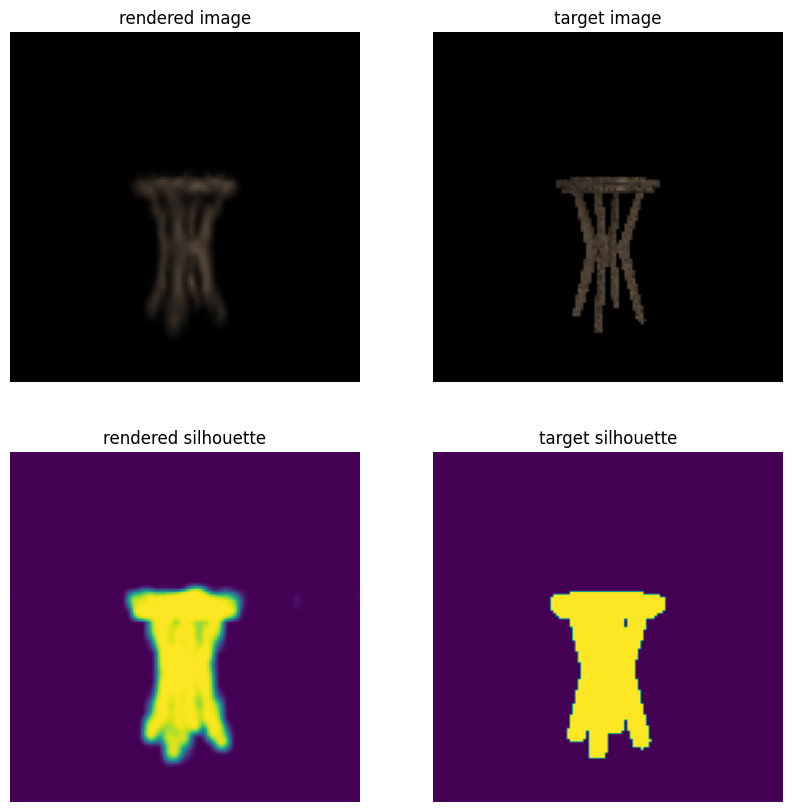

Iteration 01485: color_err = 1.98e-03 mask_err = 1.20e-02 FEA_err = 2.43e+06
Iteration 01490: color_err = 2.04e-03 mask_err = 1.16e-02 FEA_err = 2.43e+06
Iteration 01495: color_err = 2.09e-03 mask_err = 1.15e-02 FEA_err = 2.43e+06


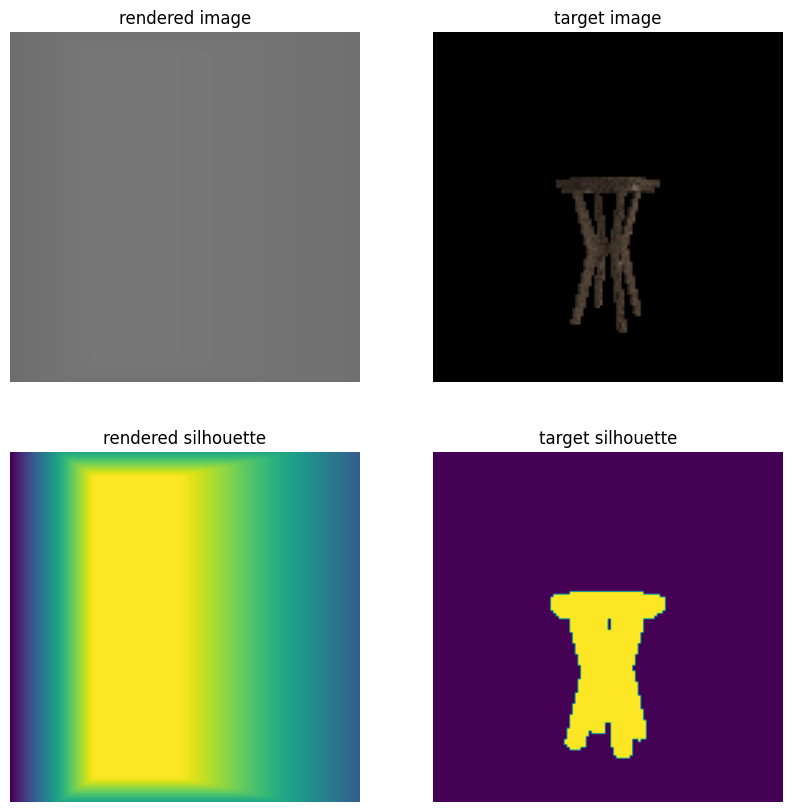

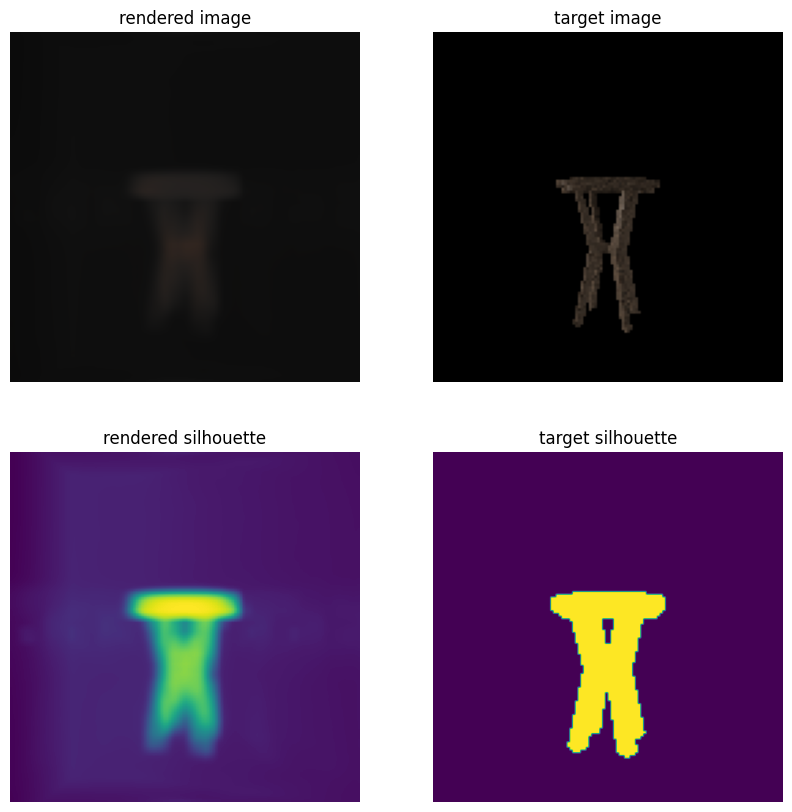

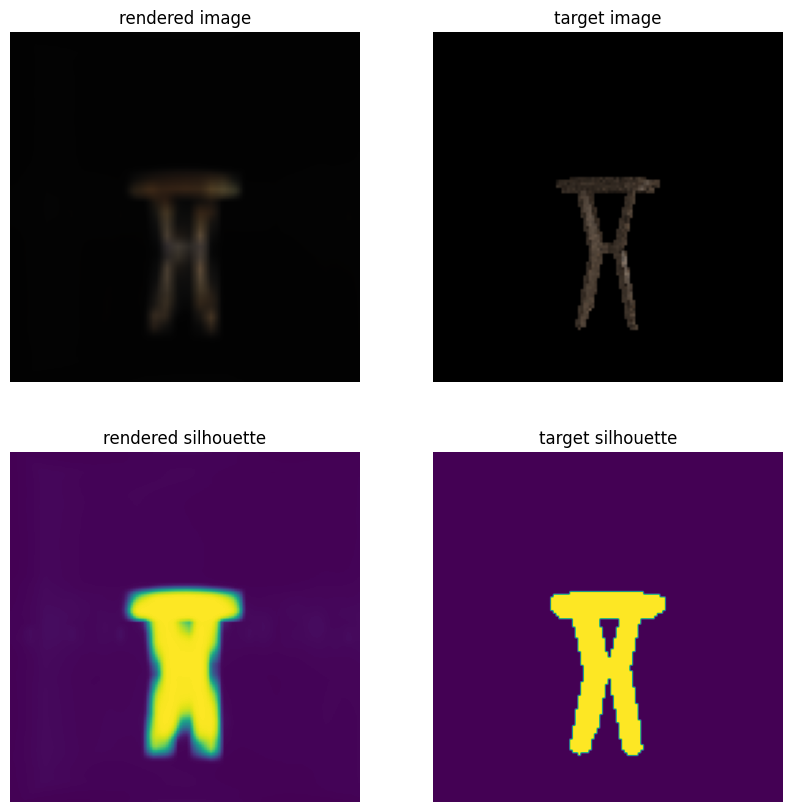

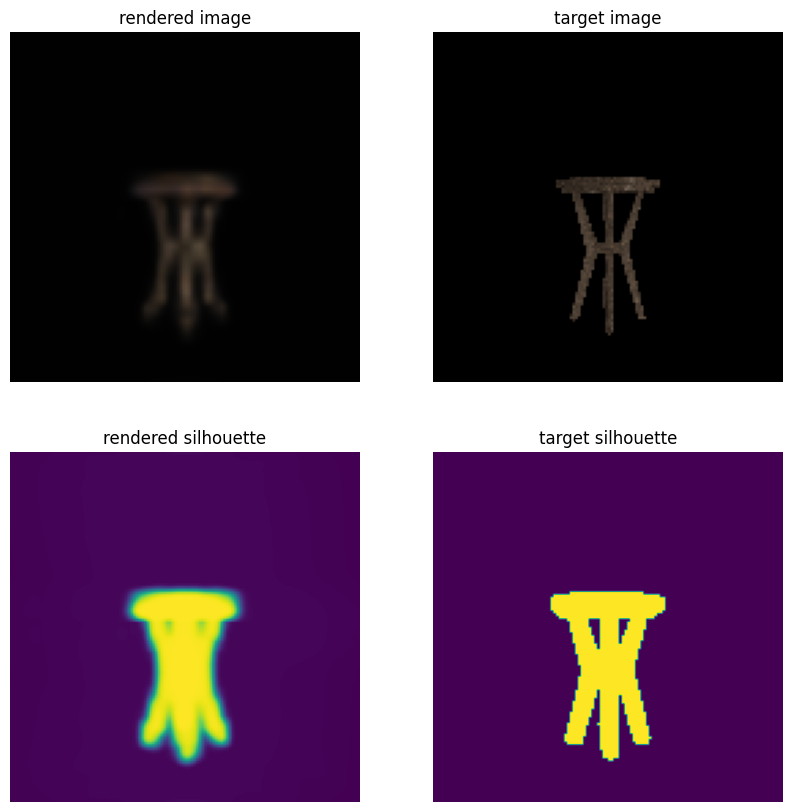

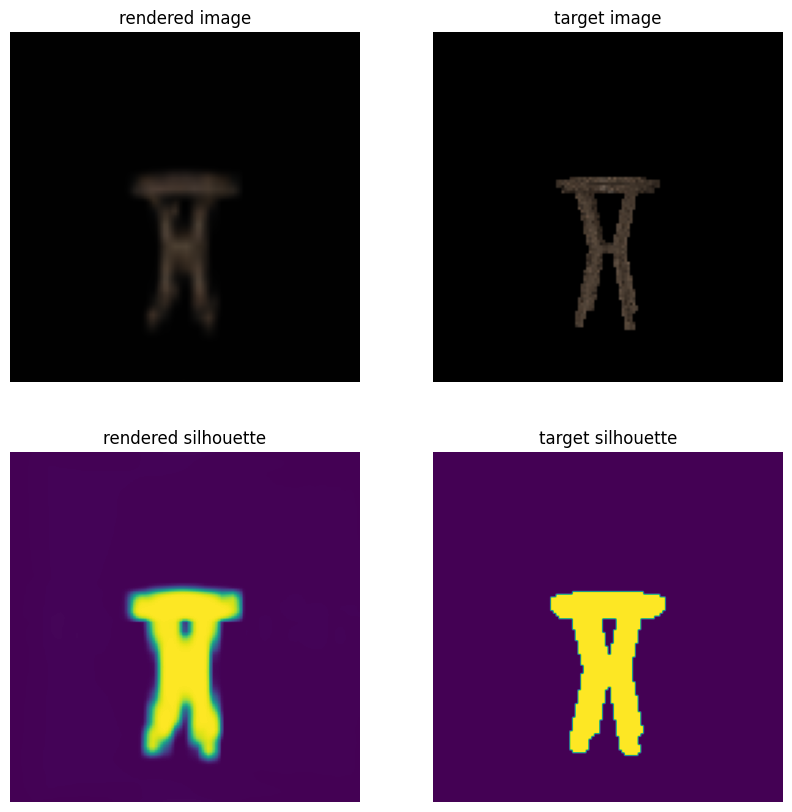

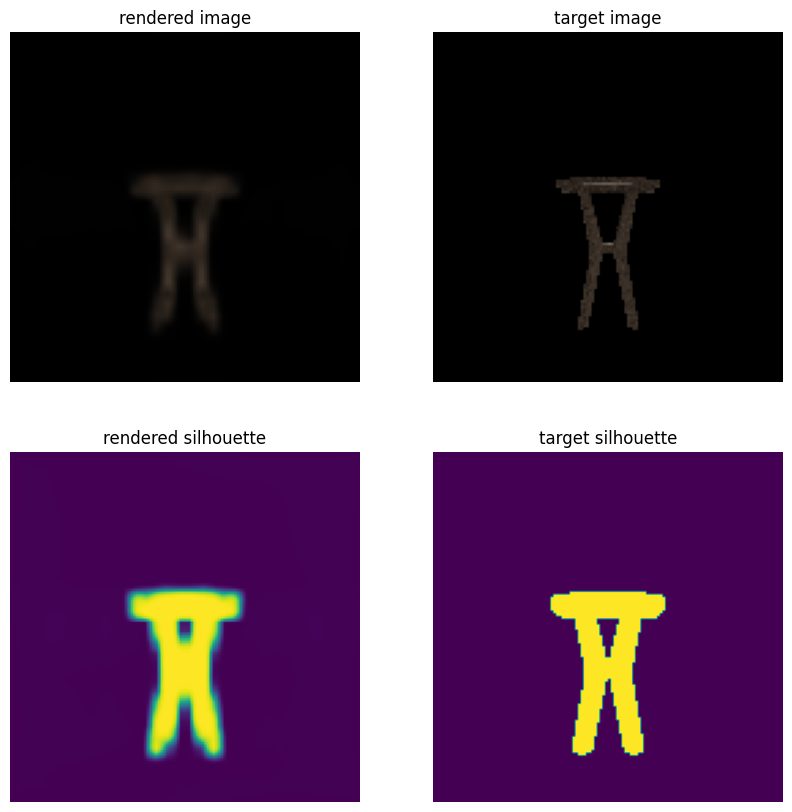

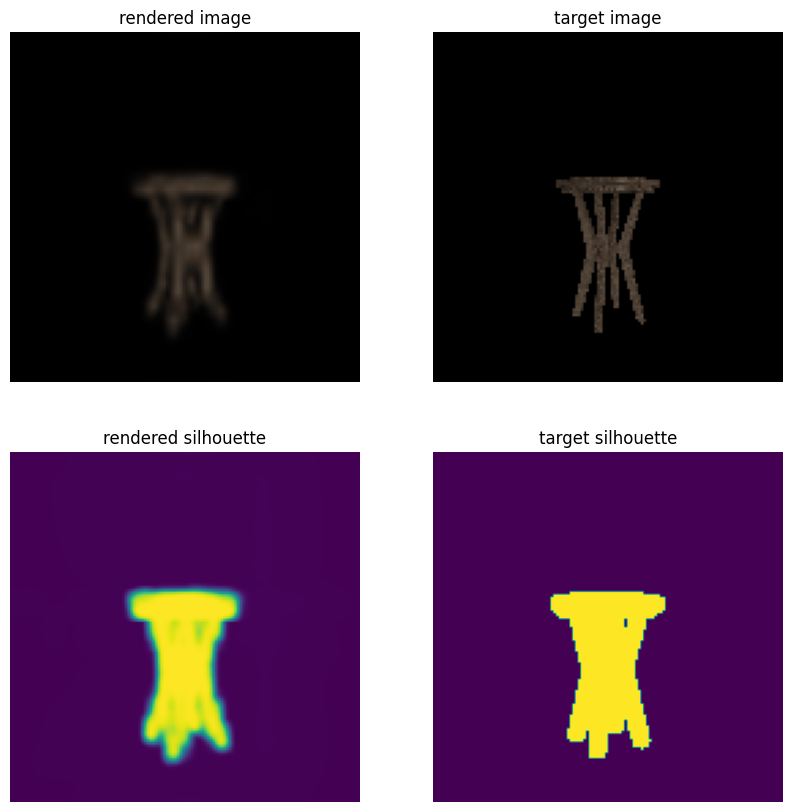

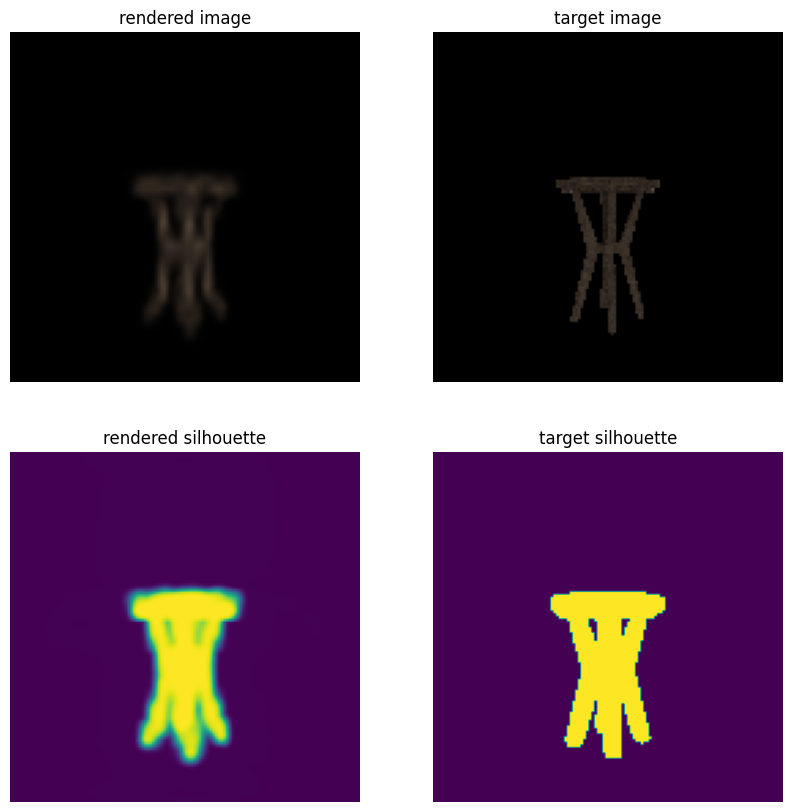

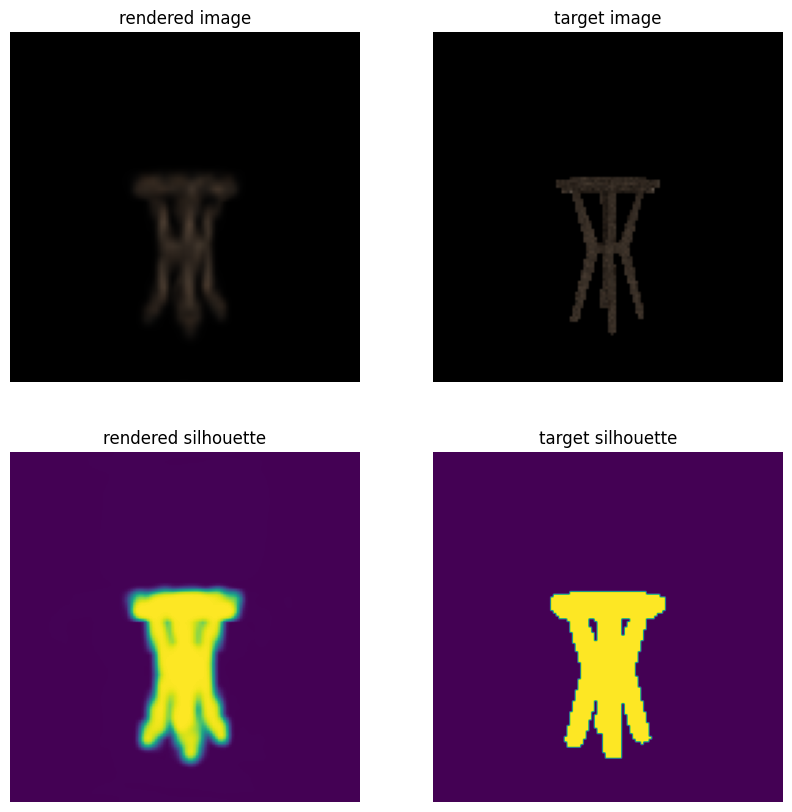

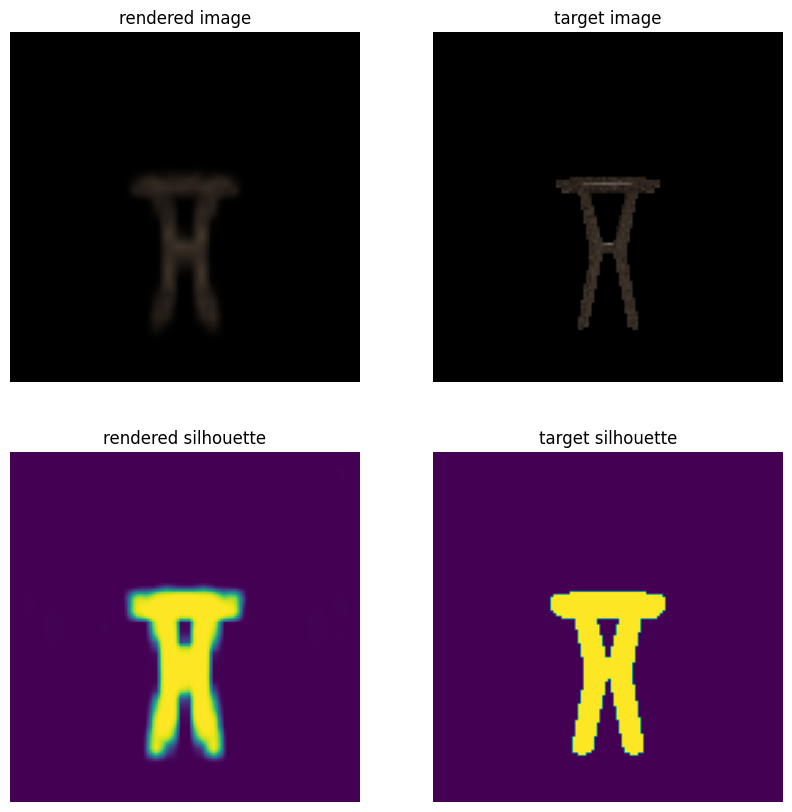

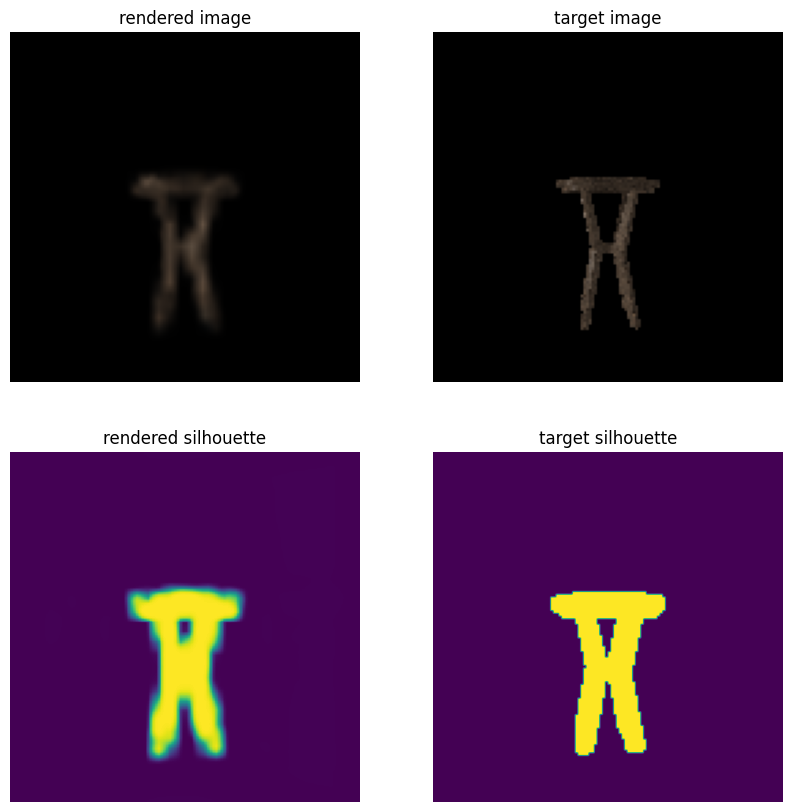

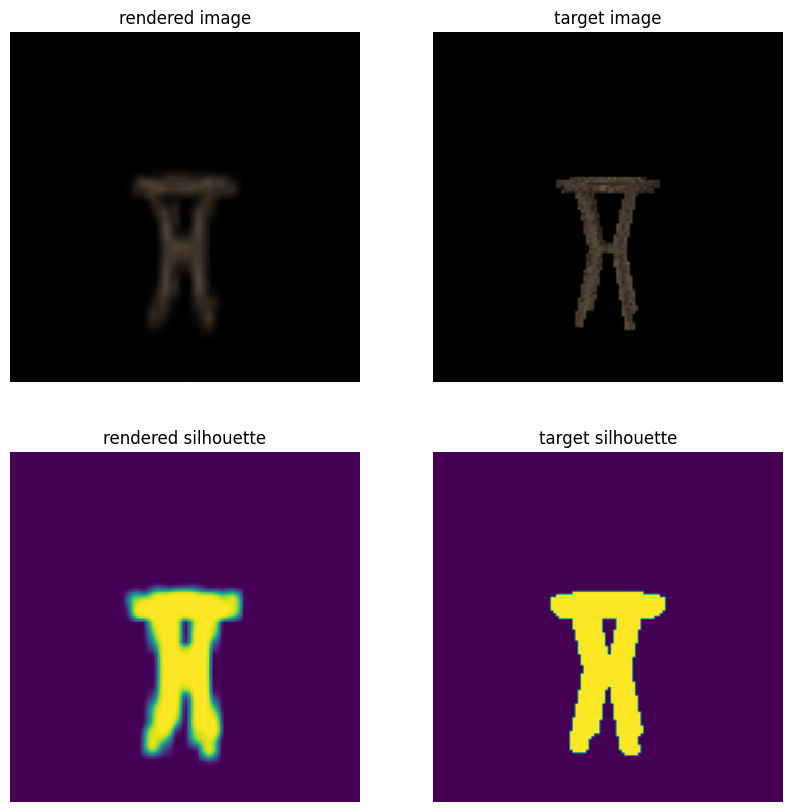

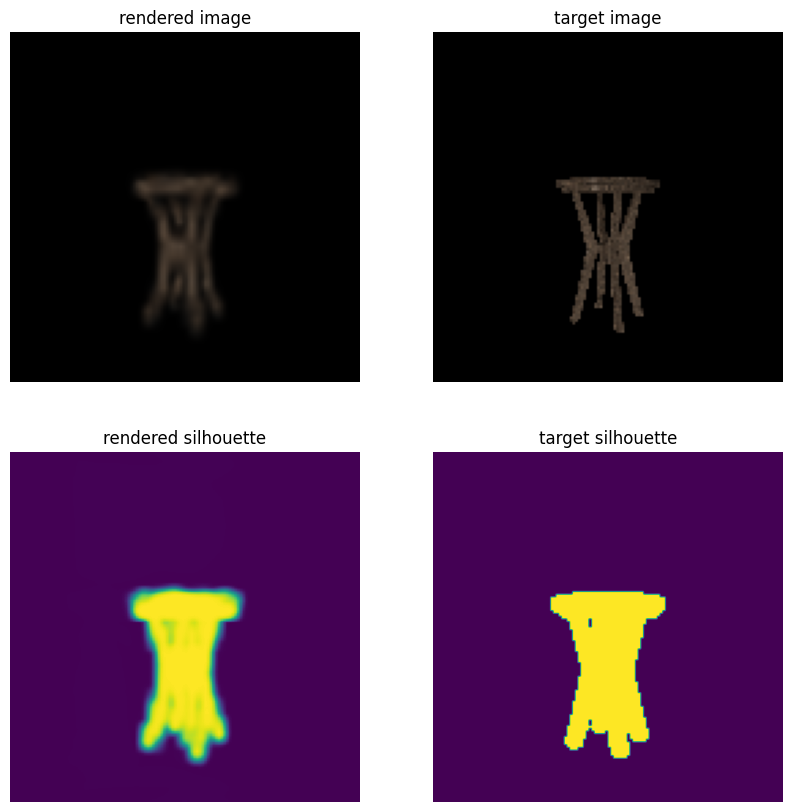

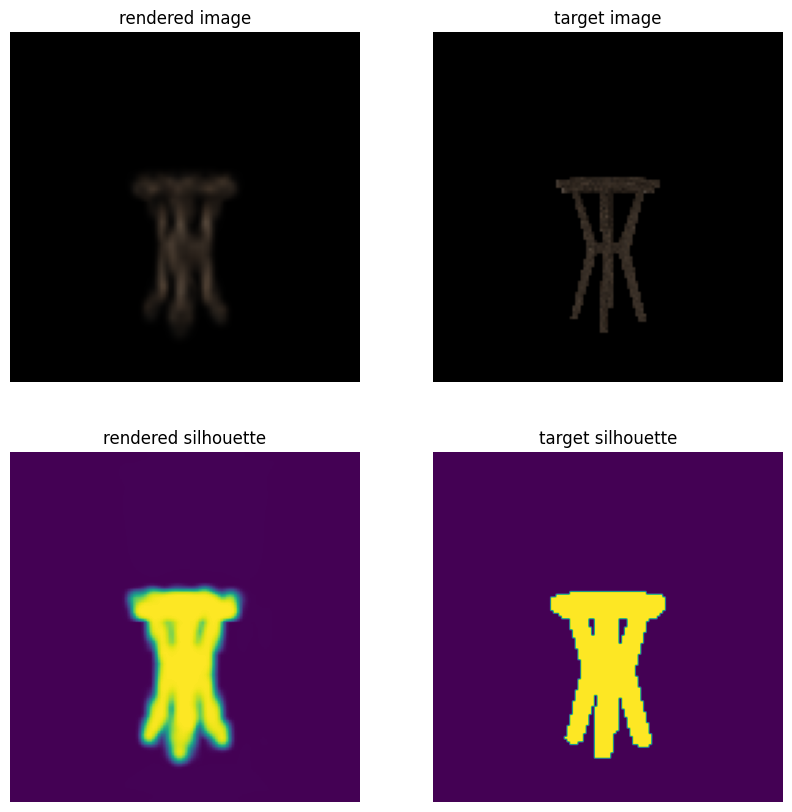

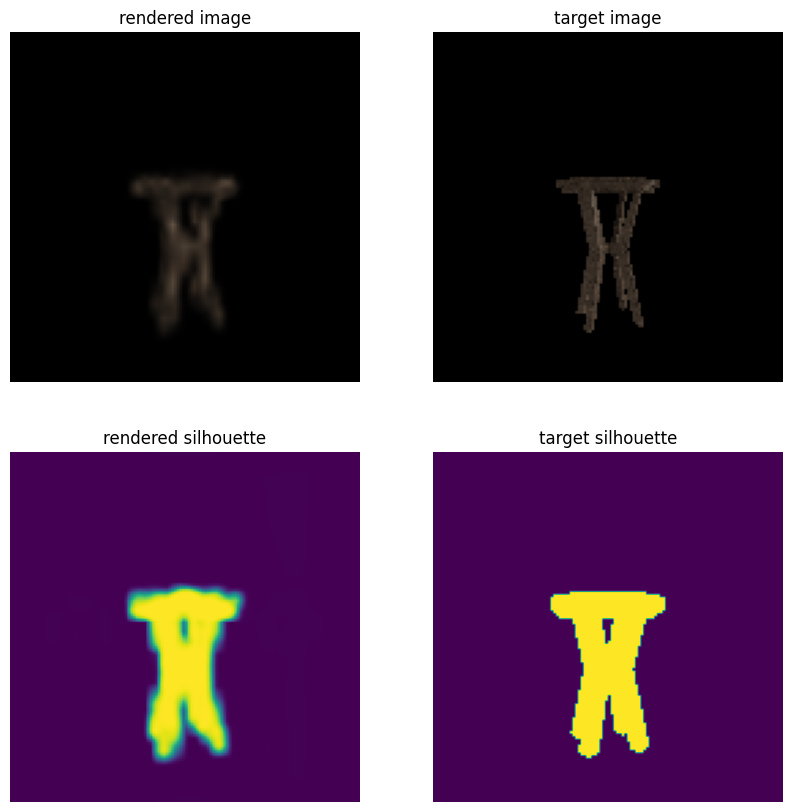

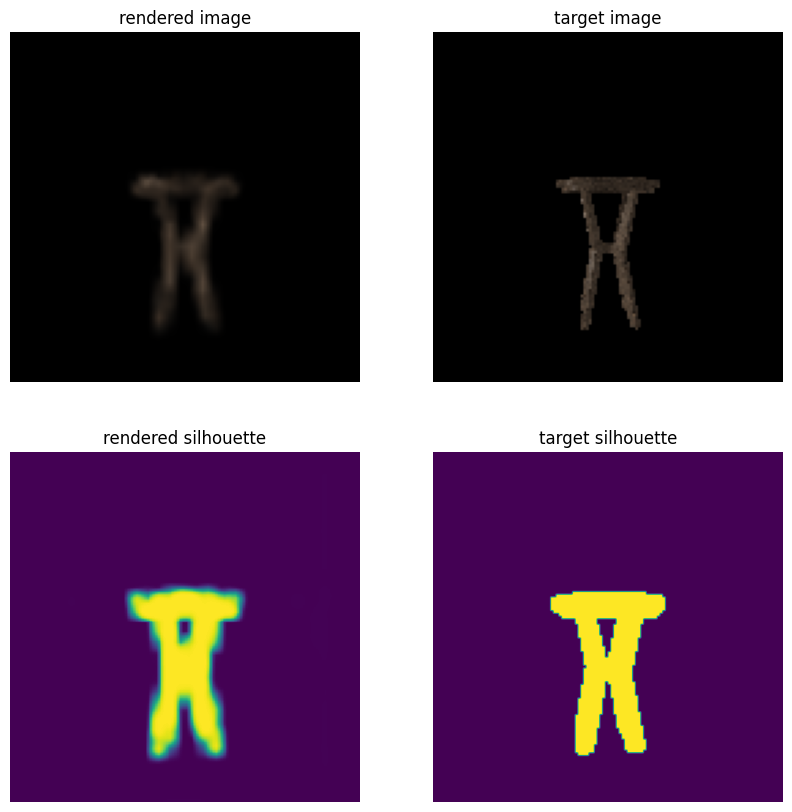

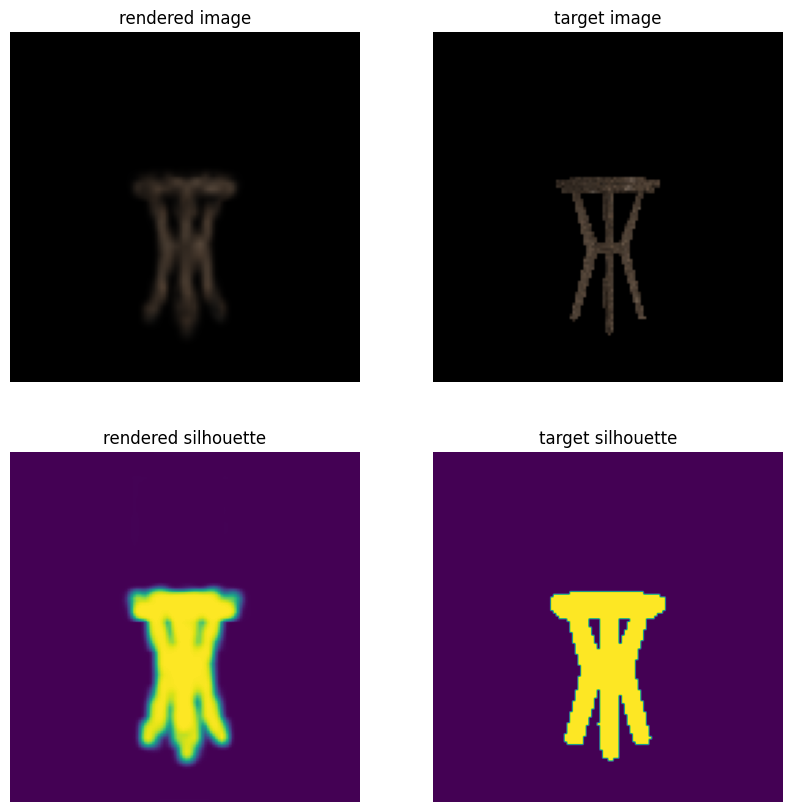

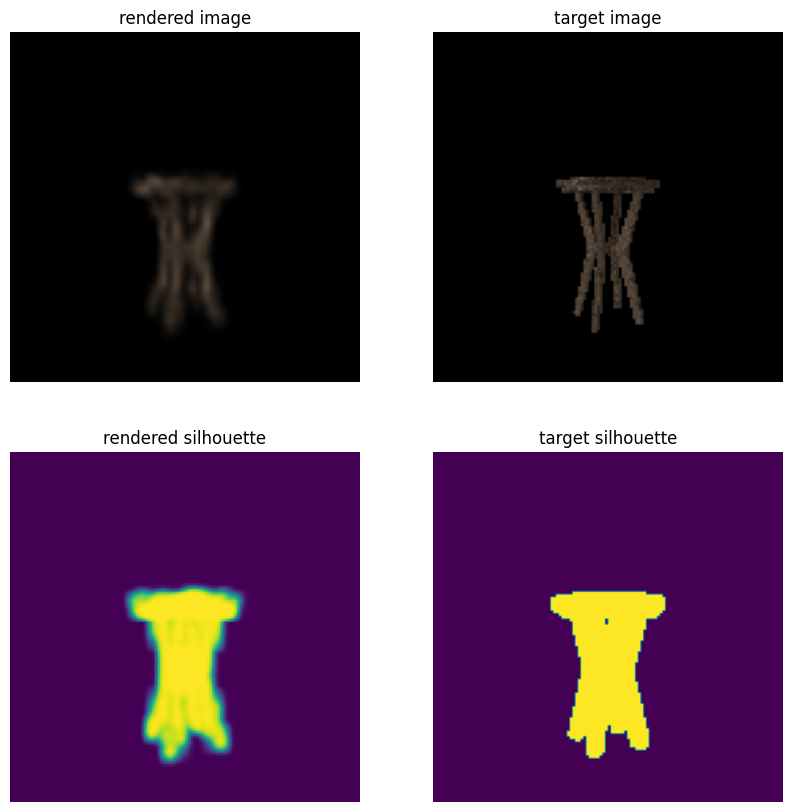

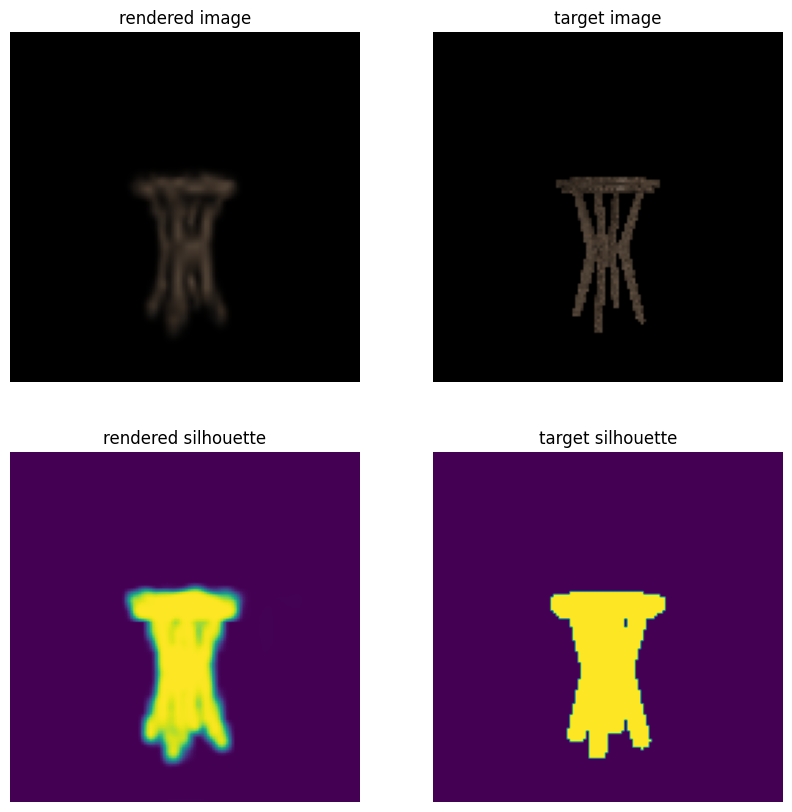

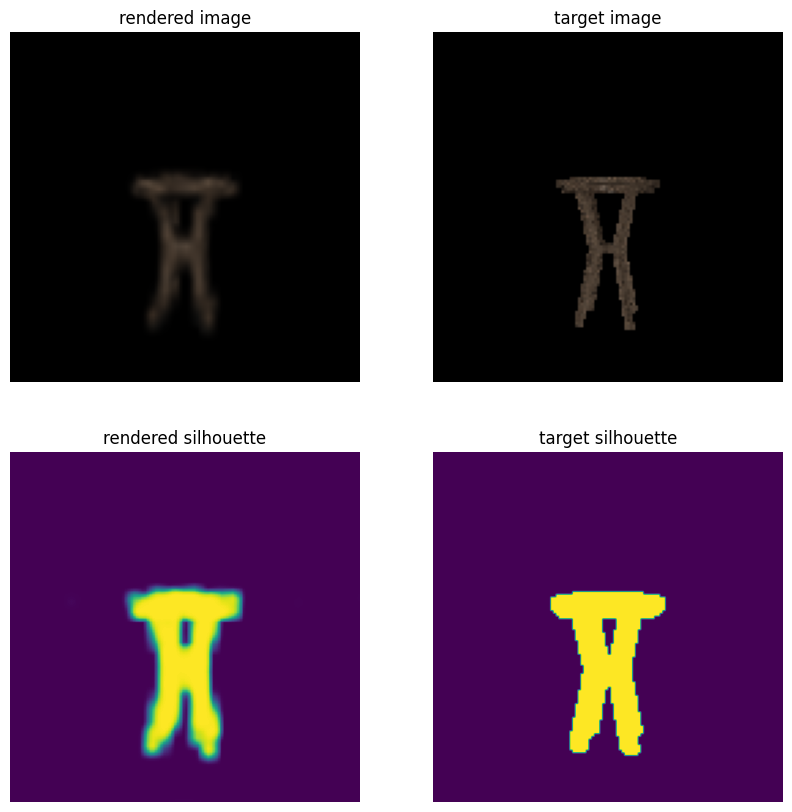

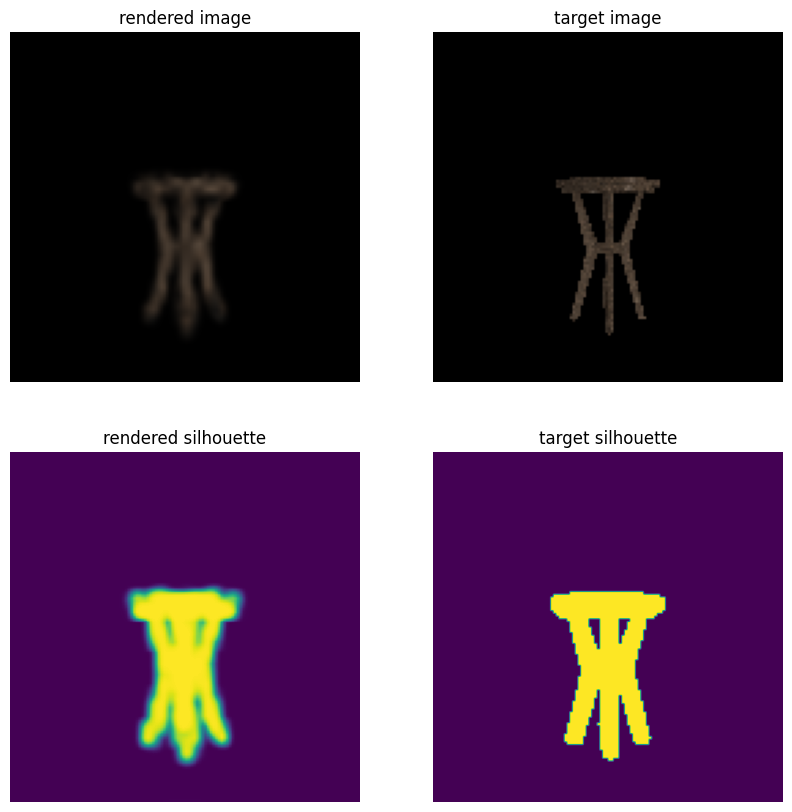

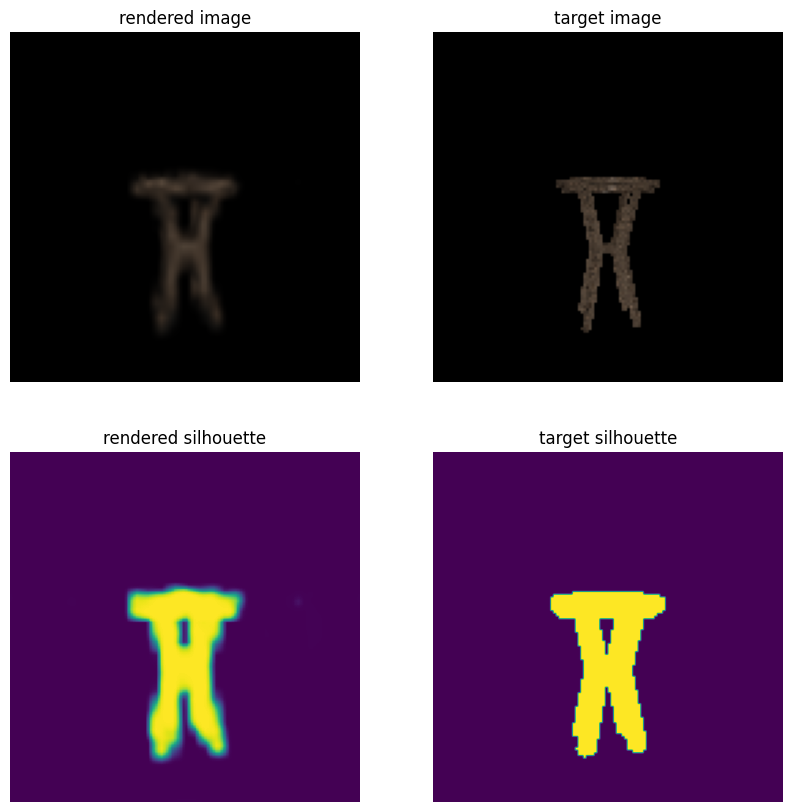

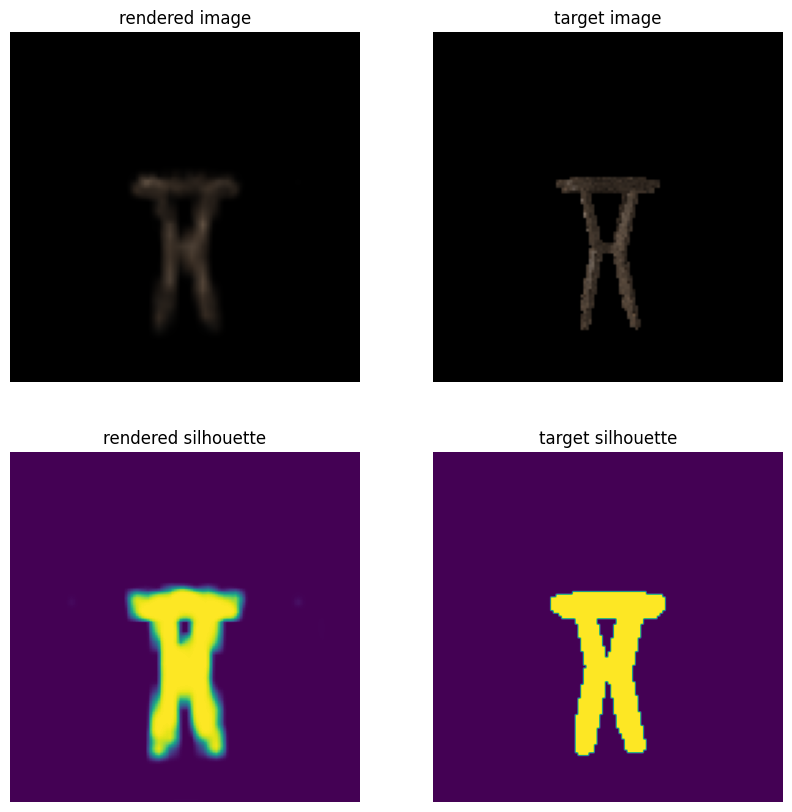

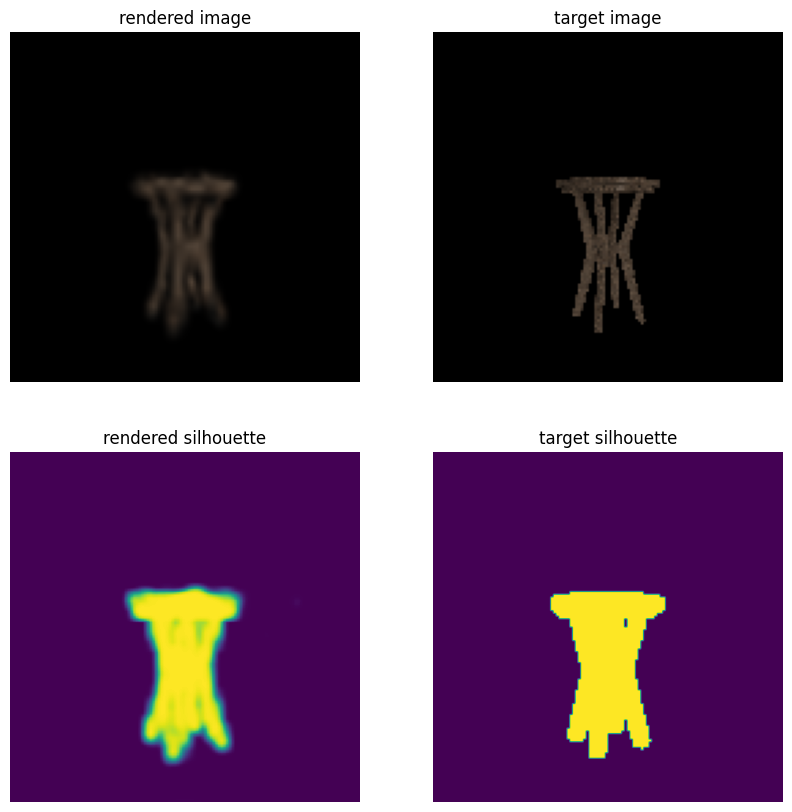

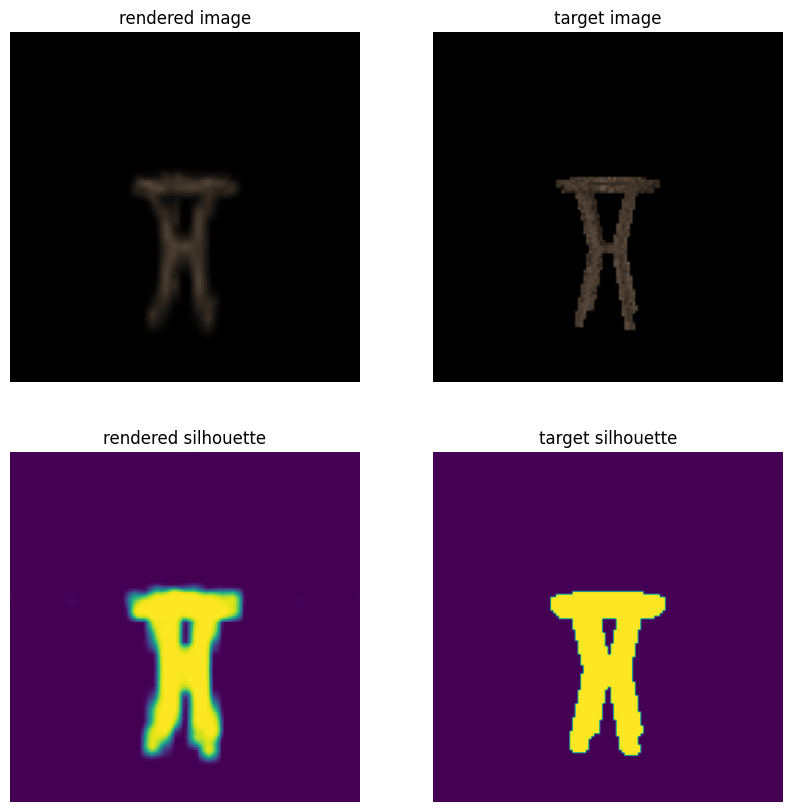

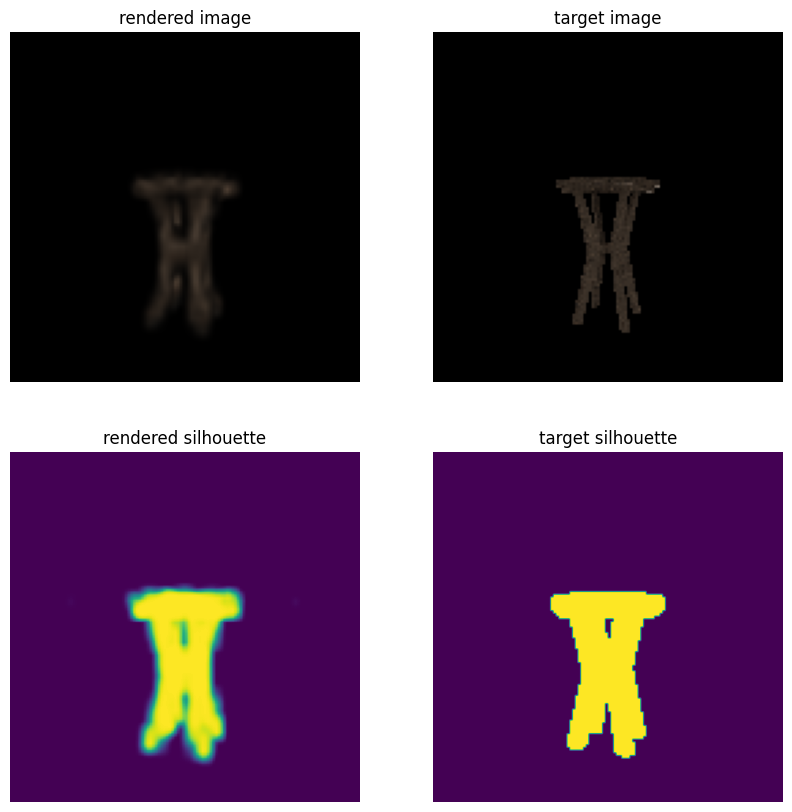

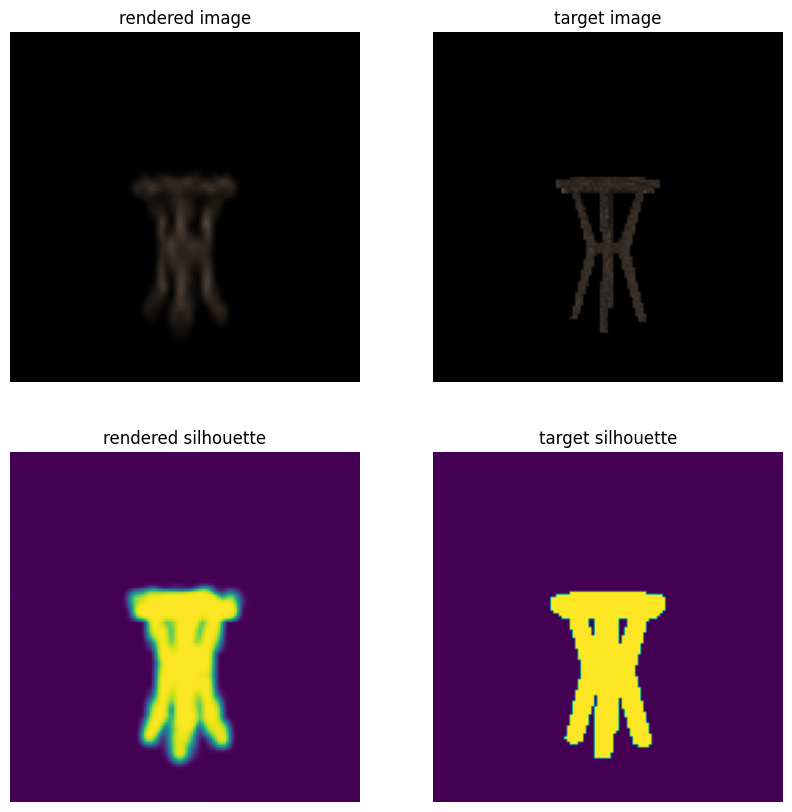

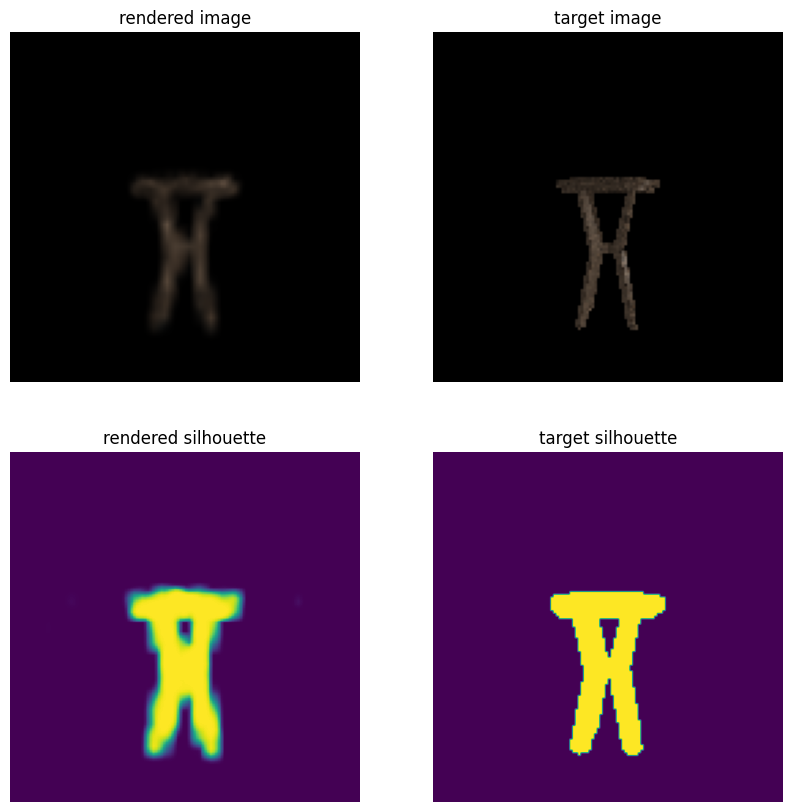

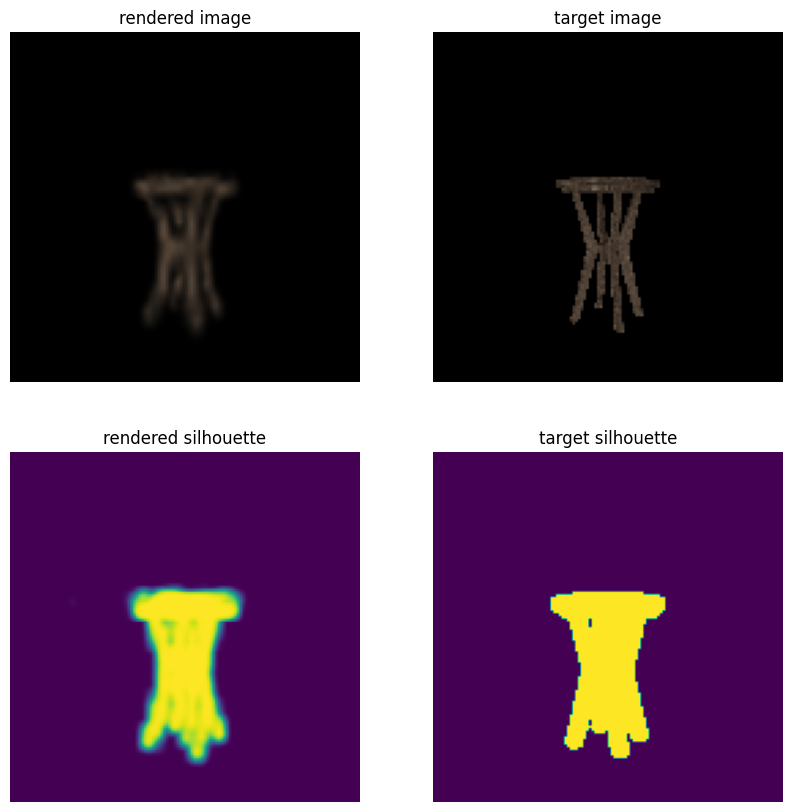

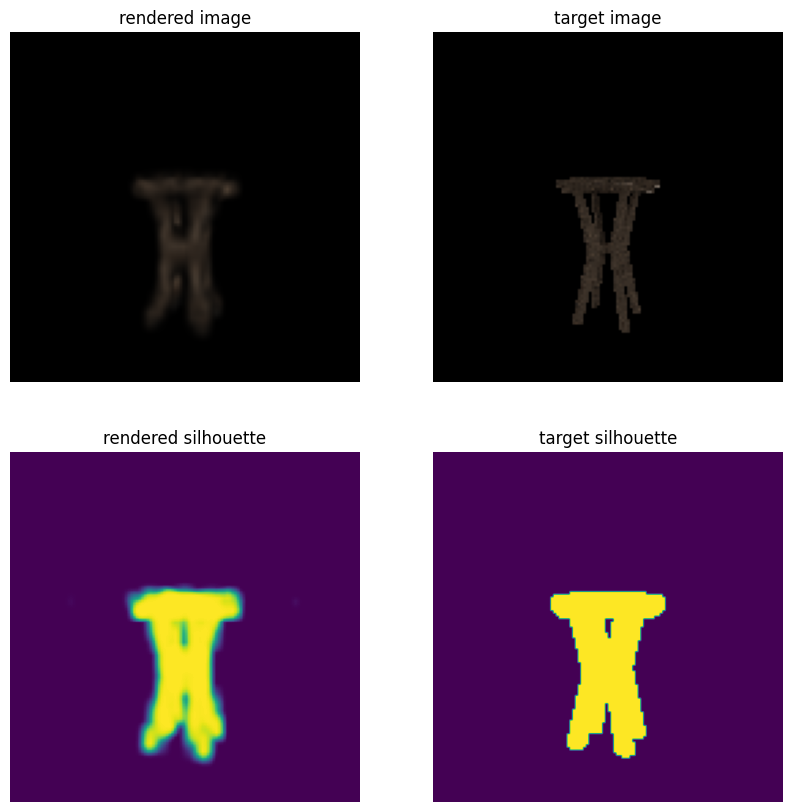

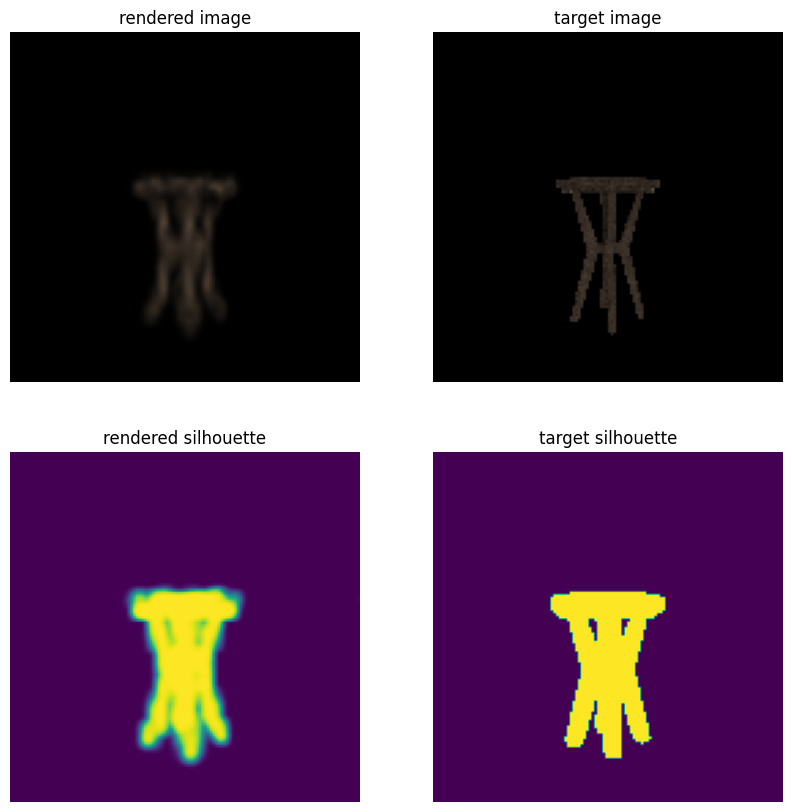

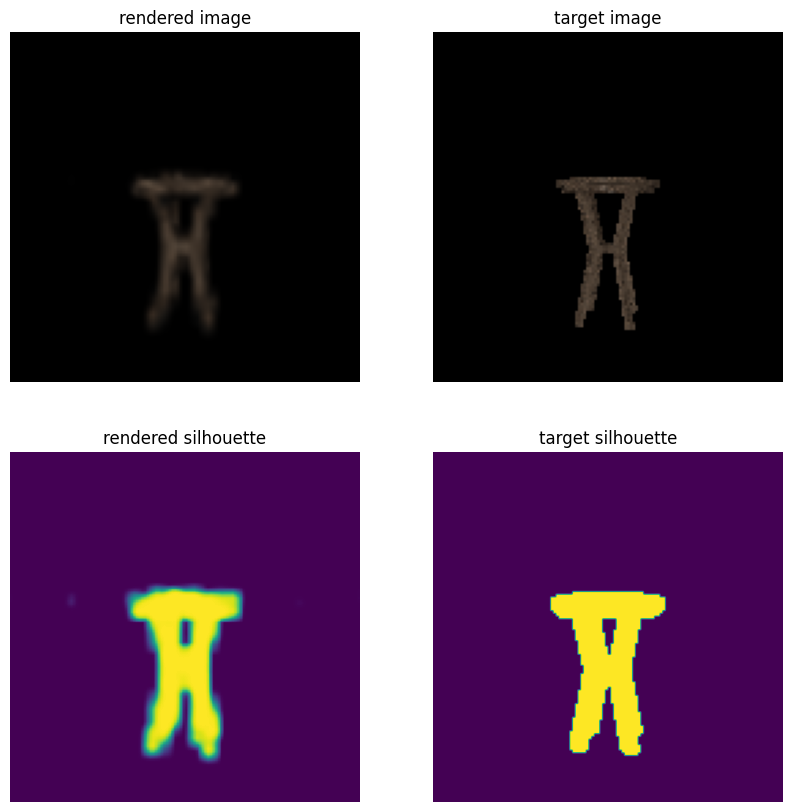

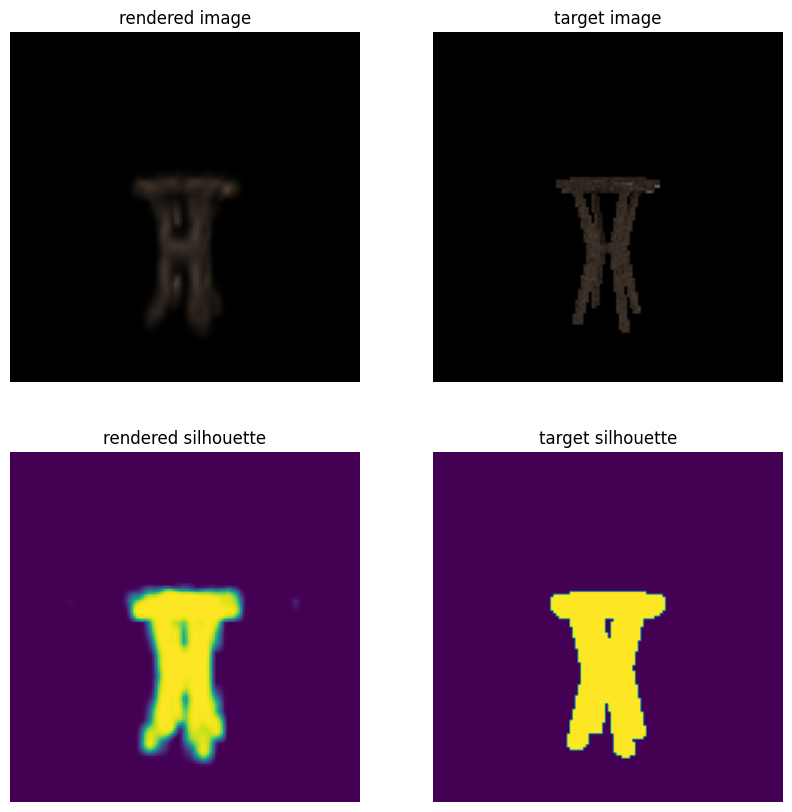

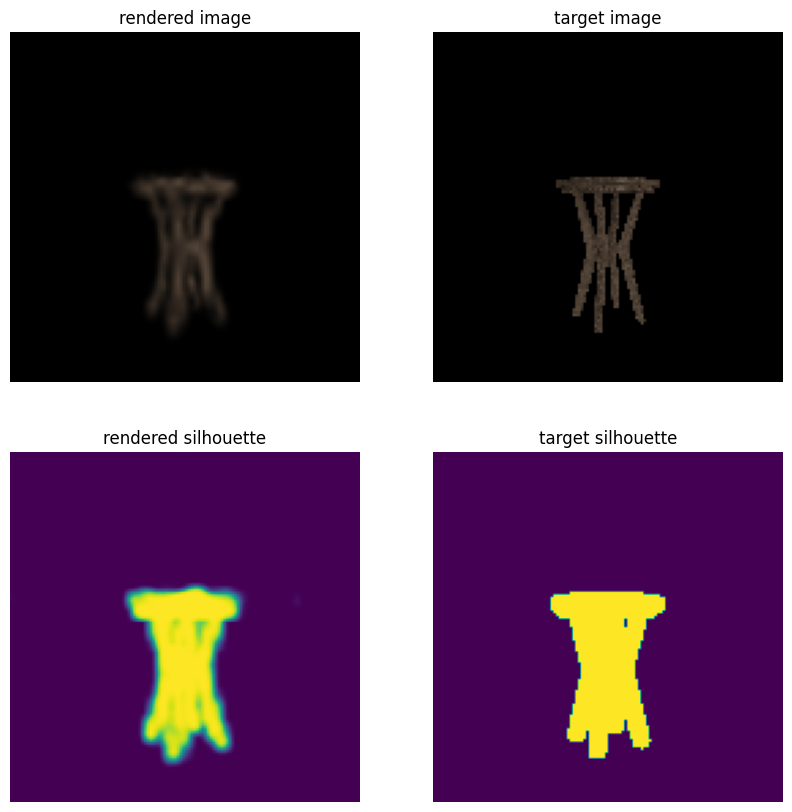

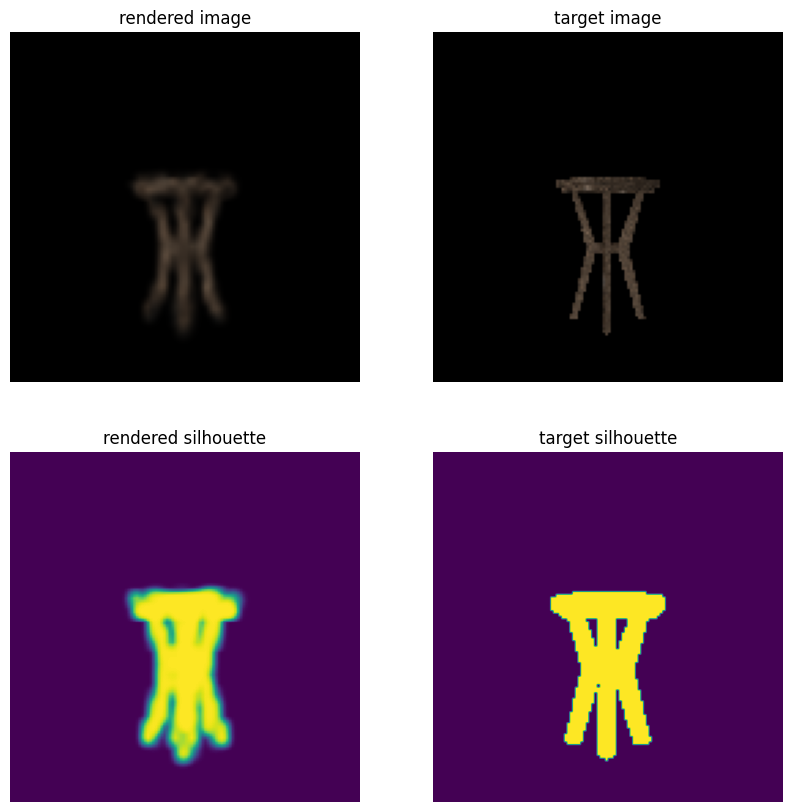

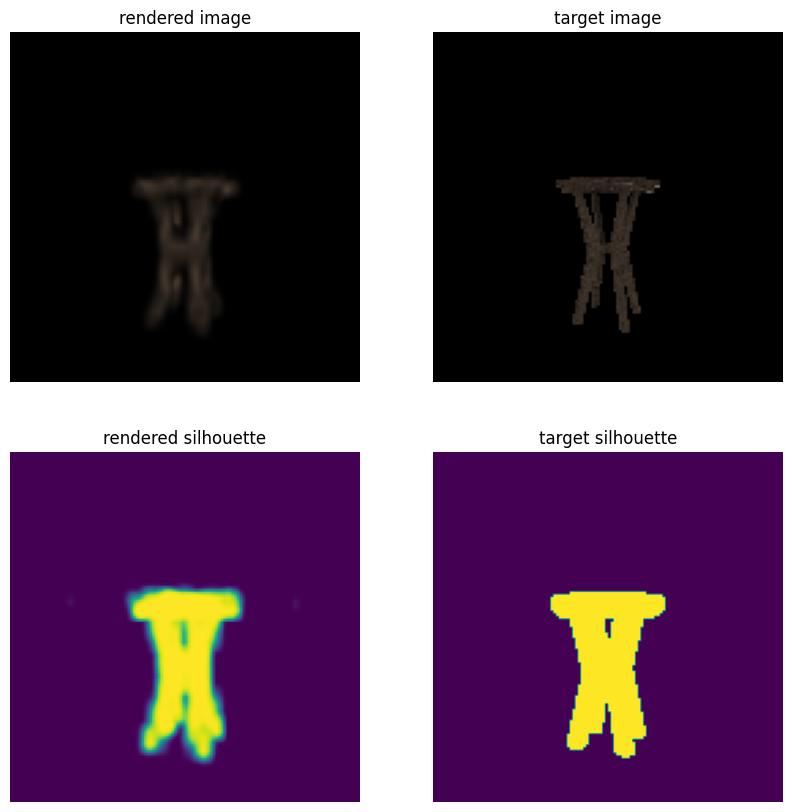

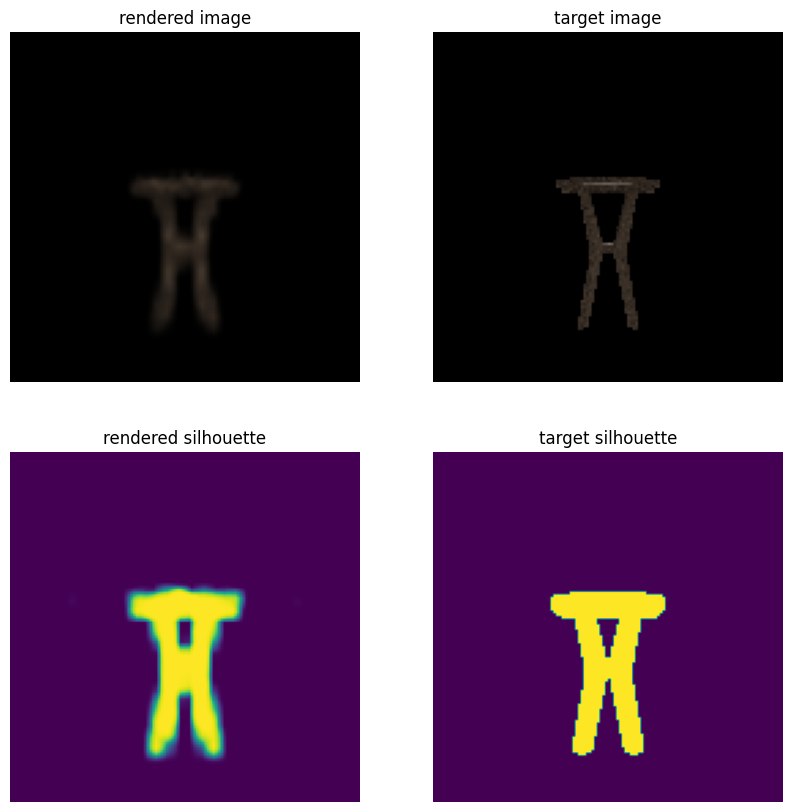

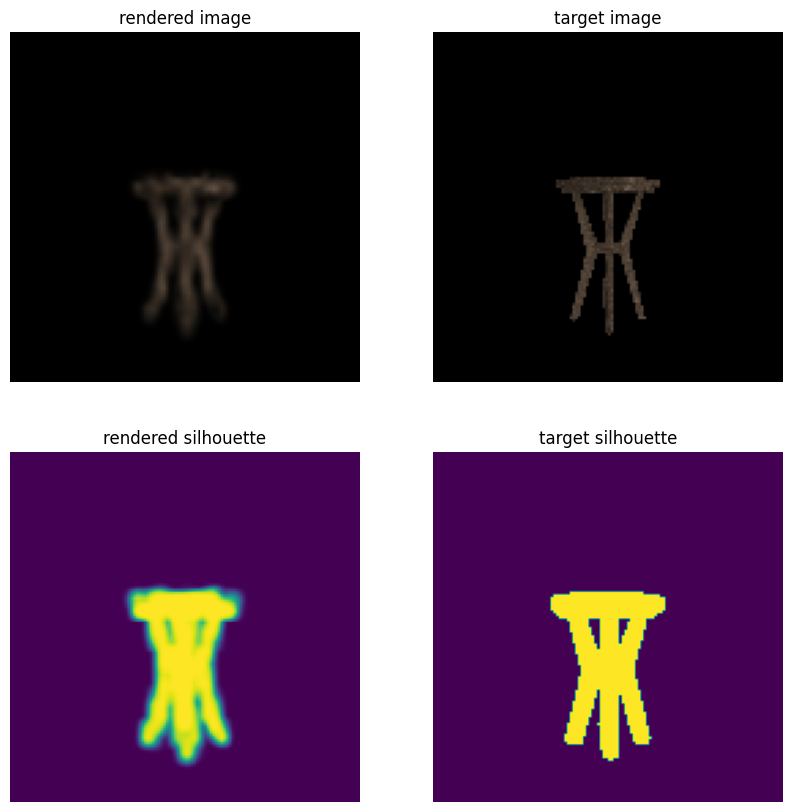

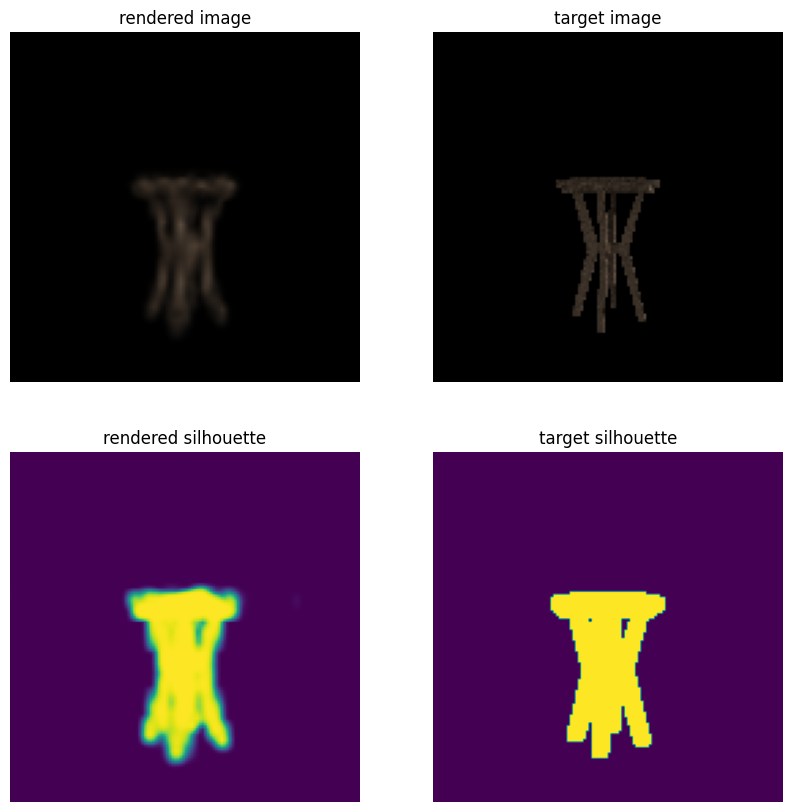

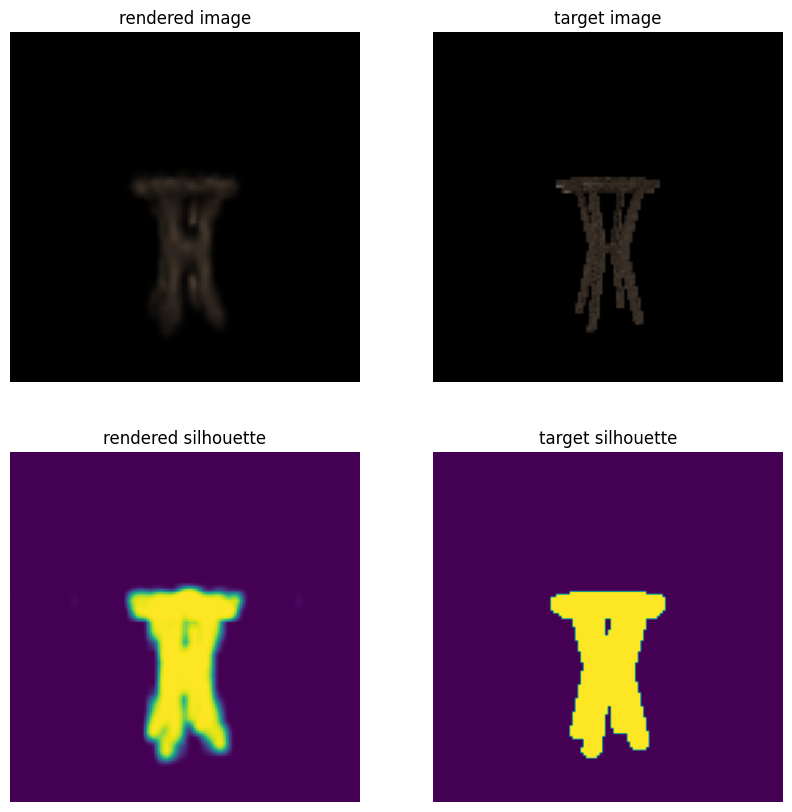

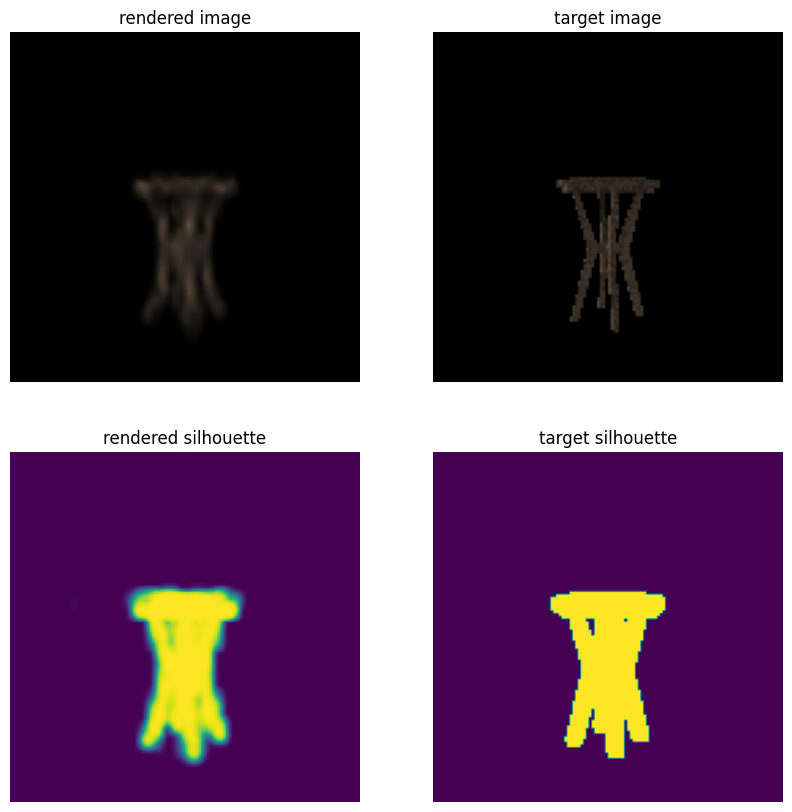

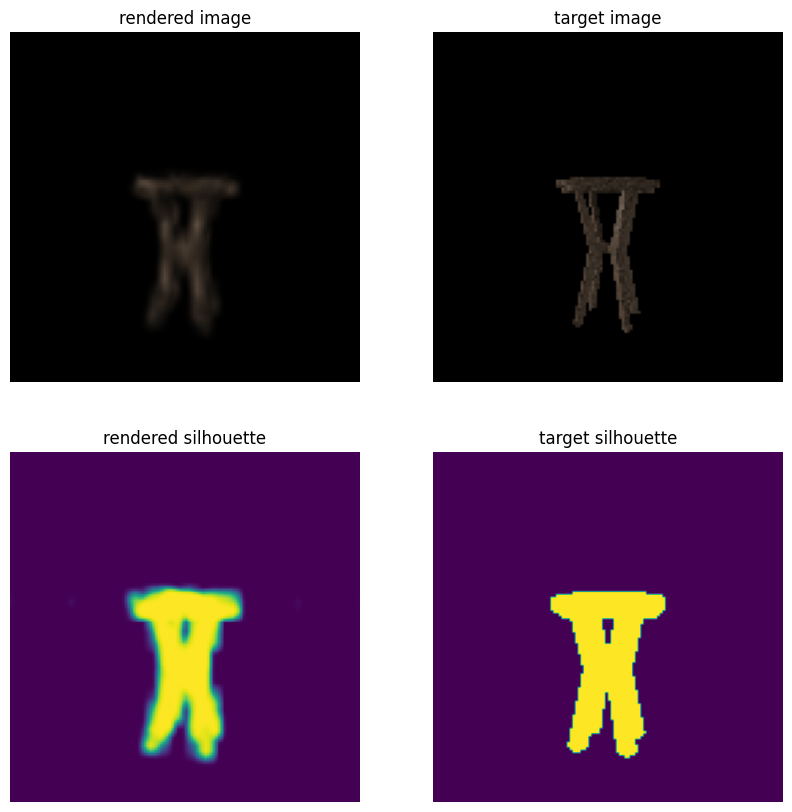

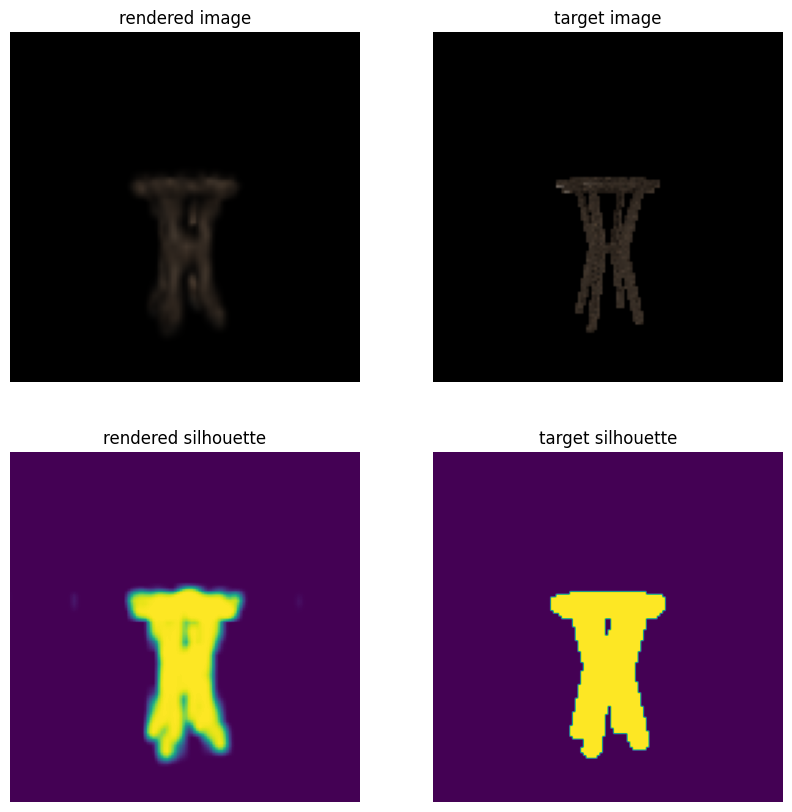

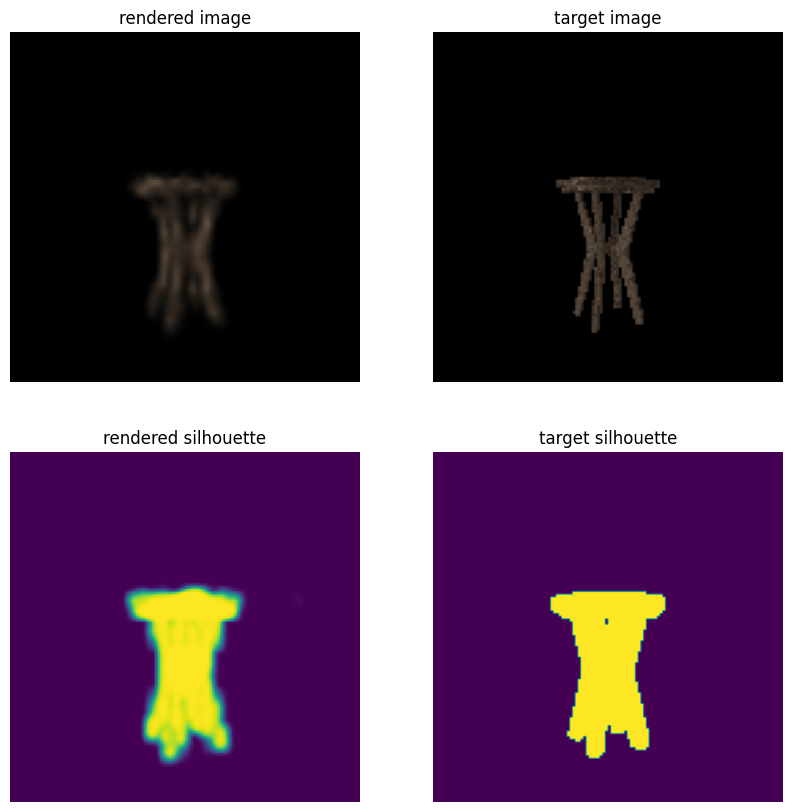

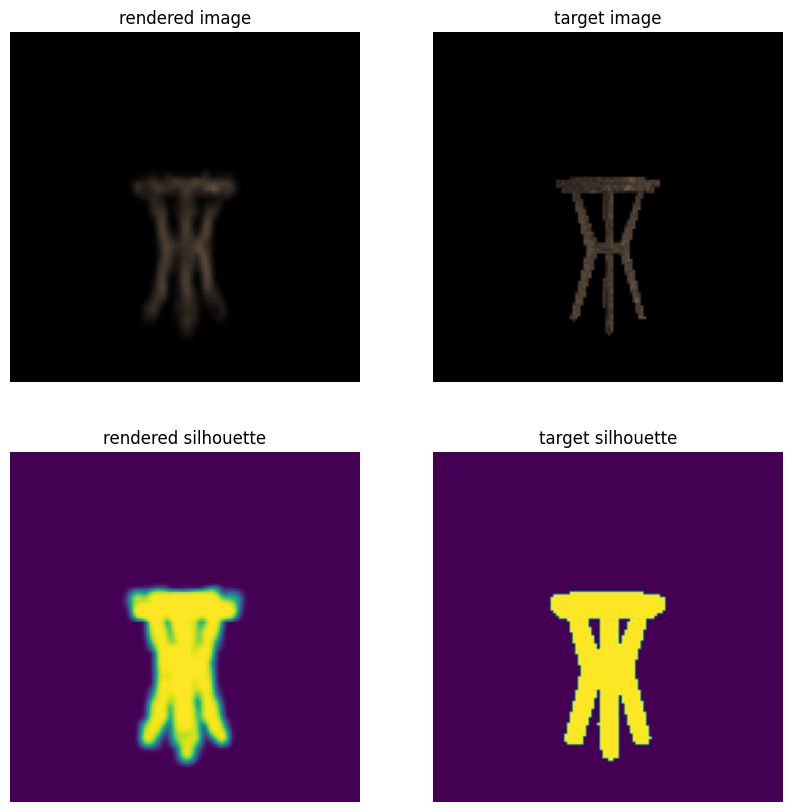

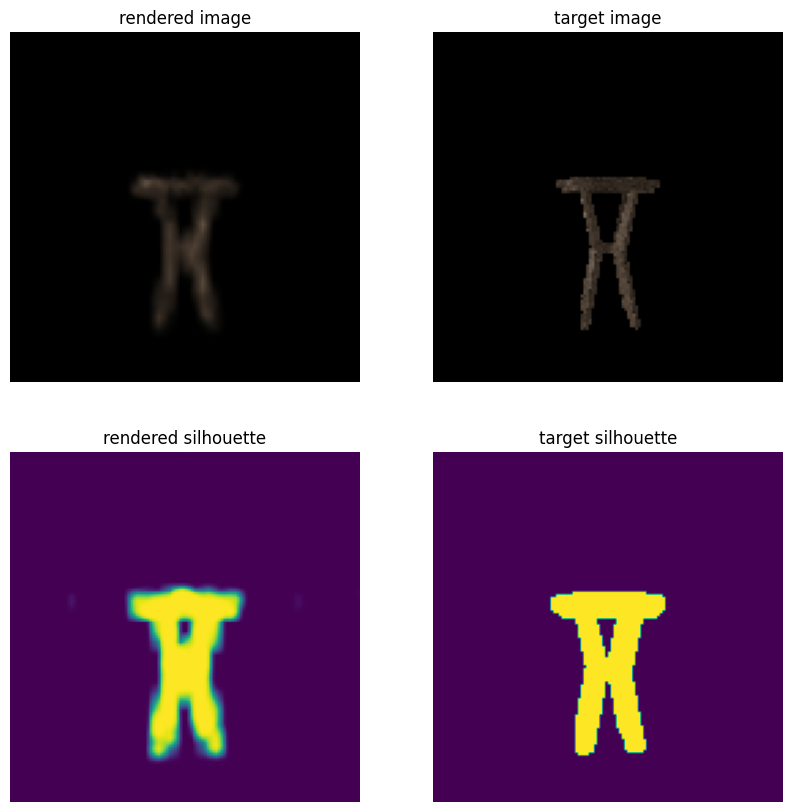

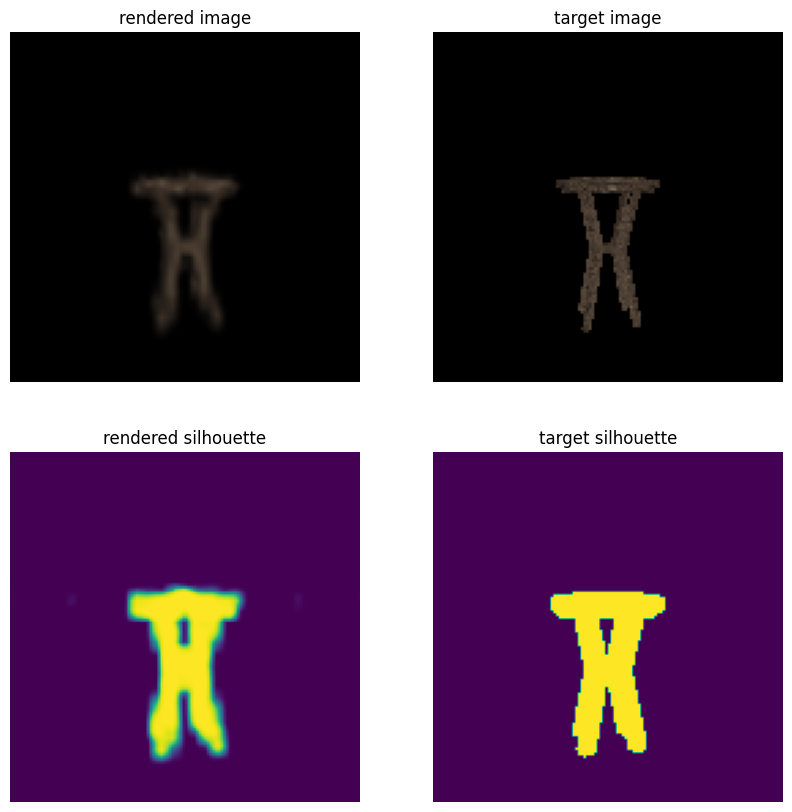

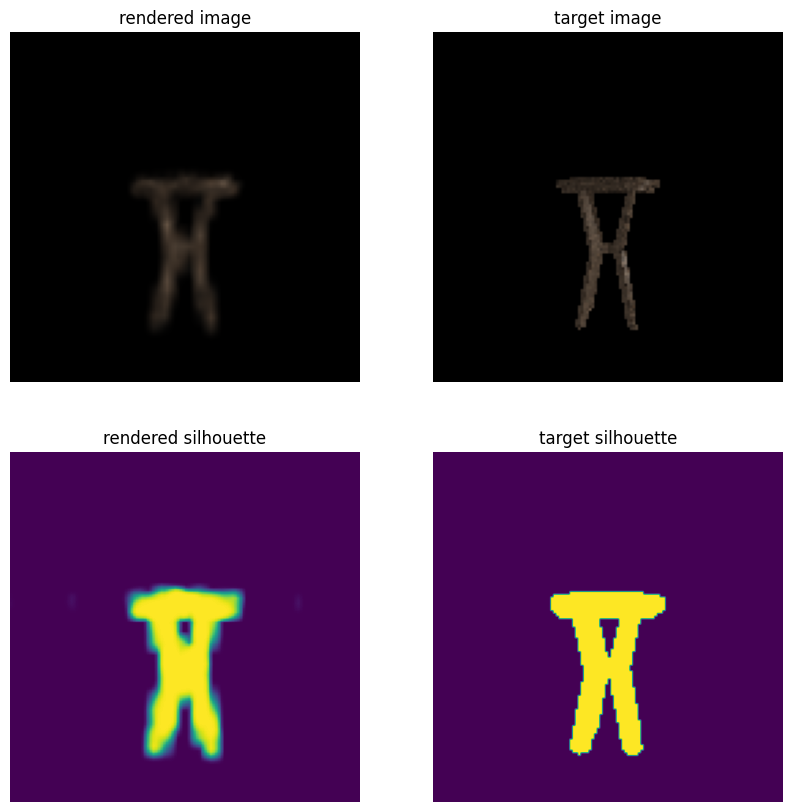

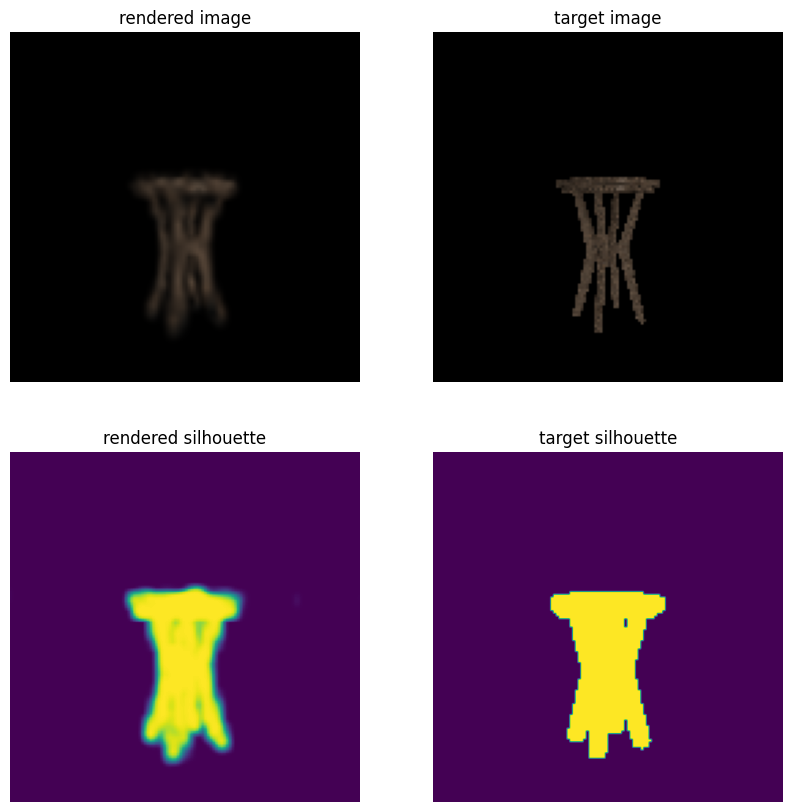

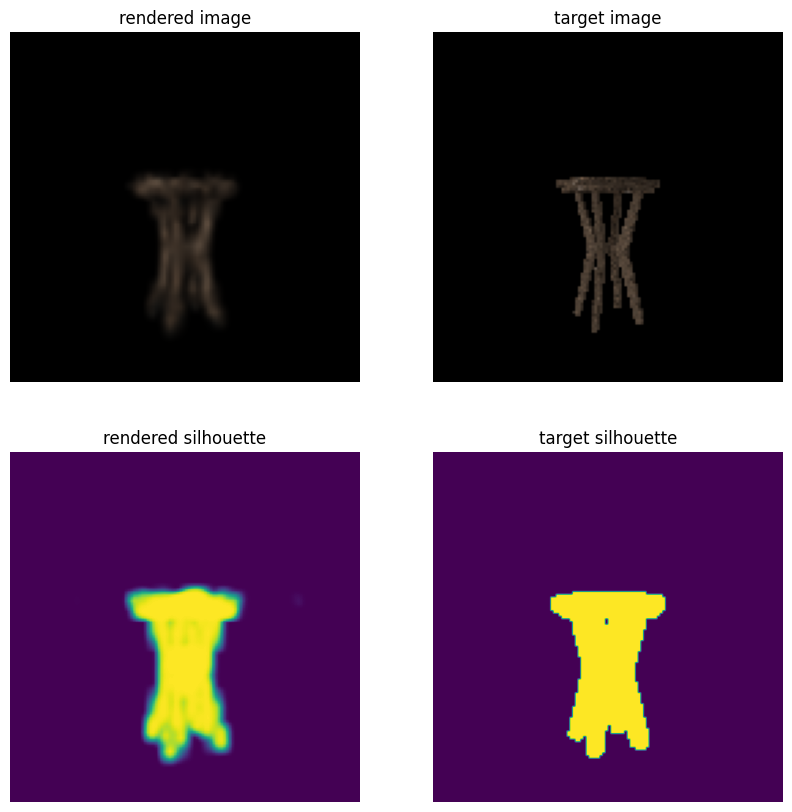

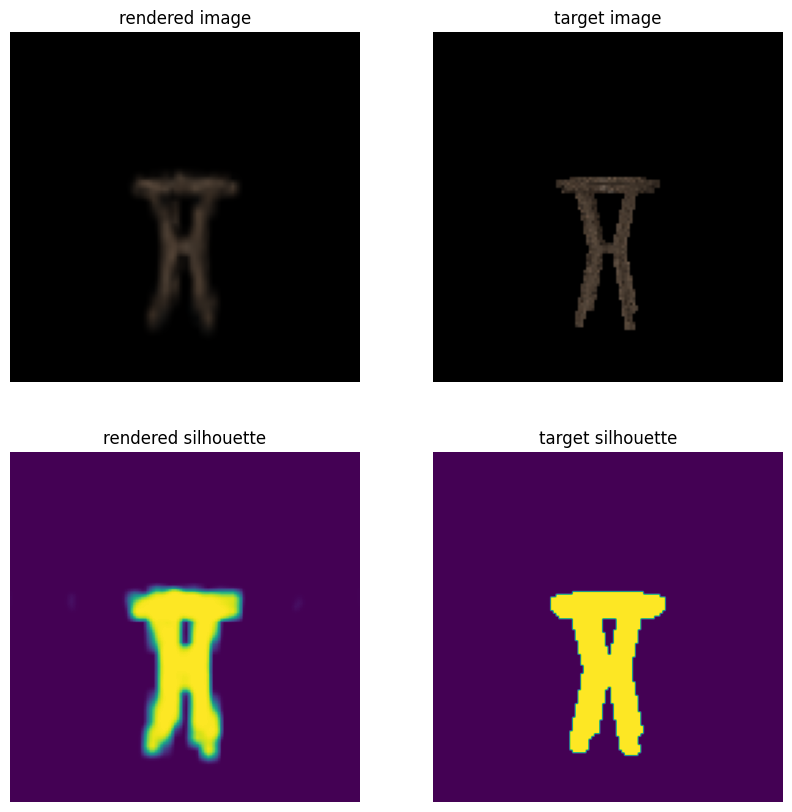

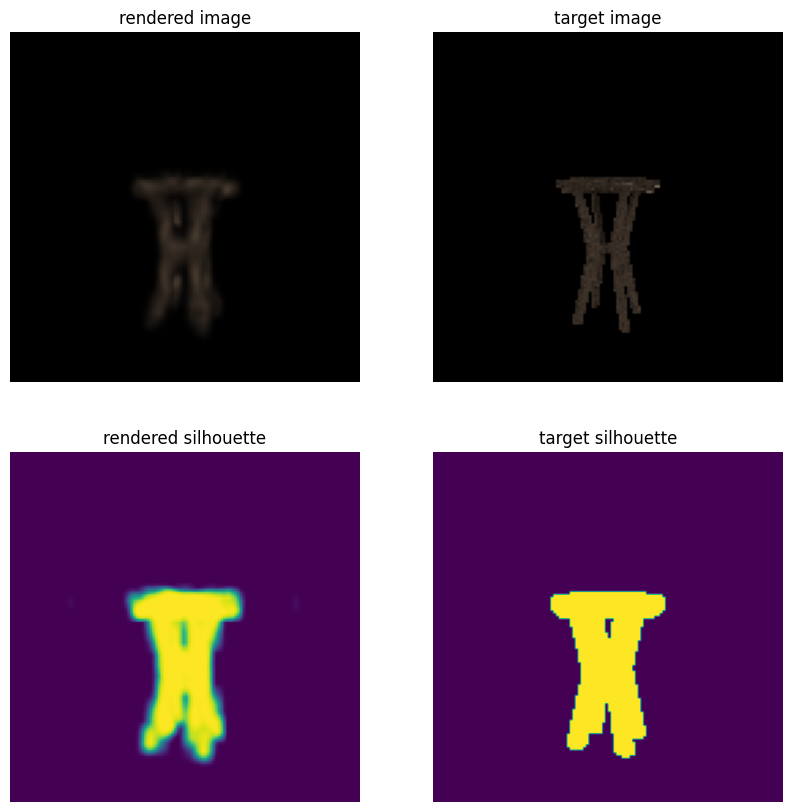

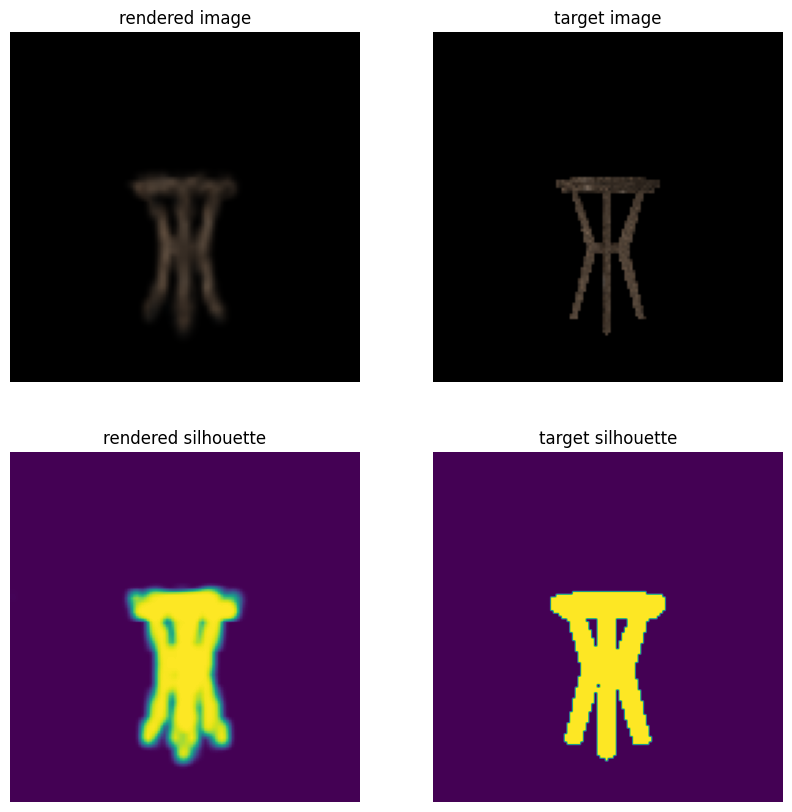

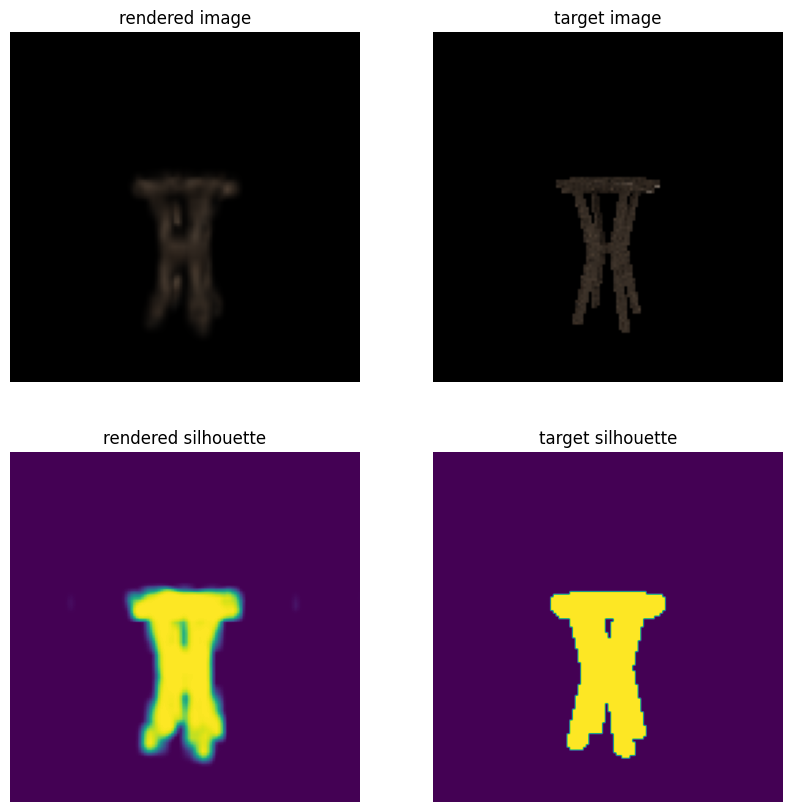

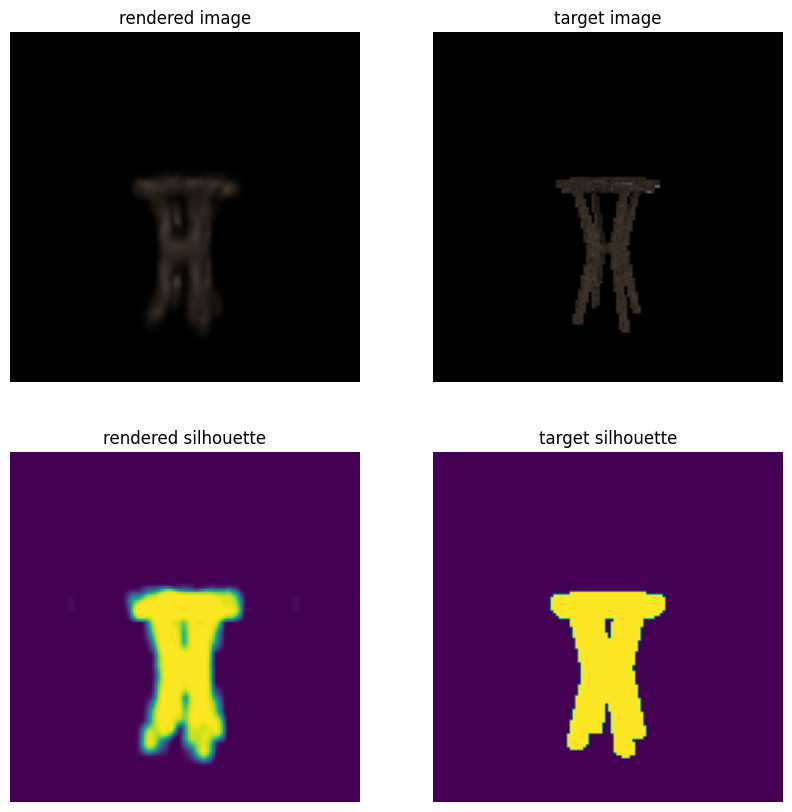

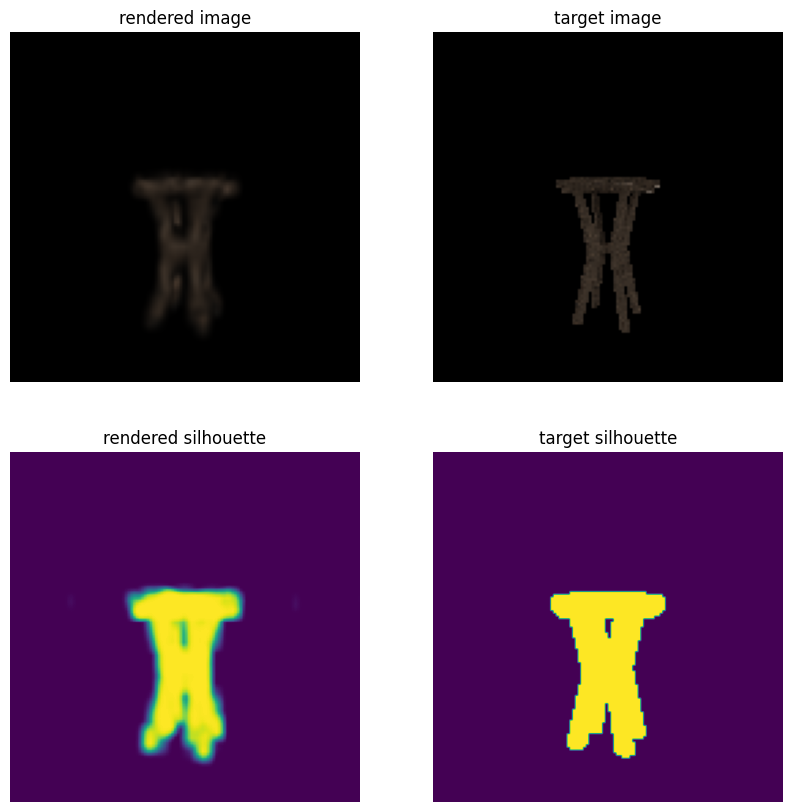

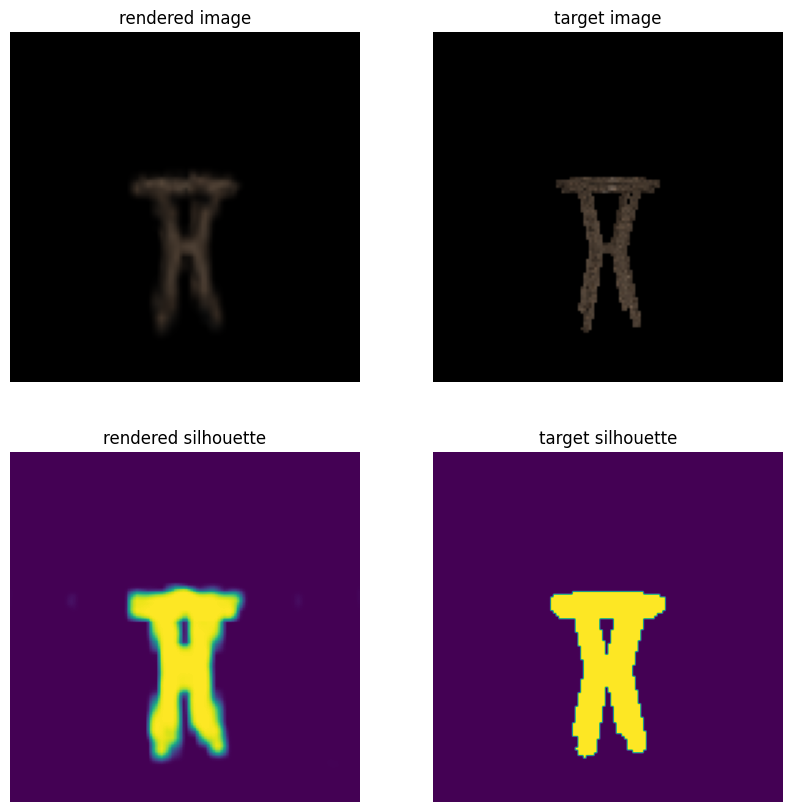

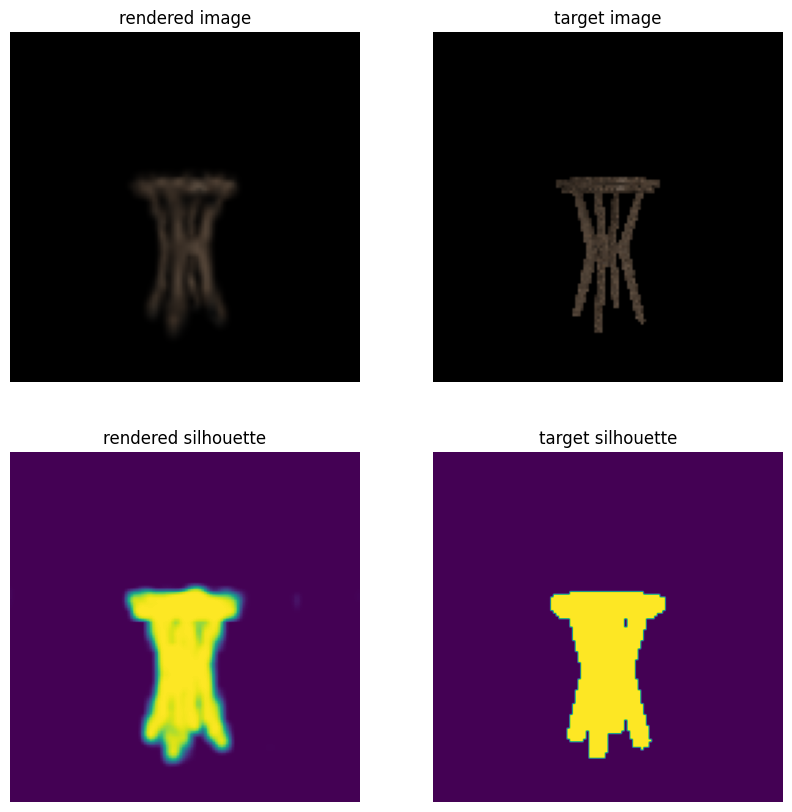

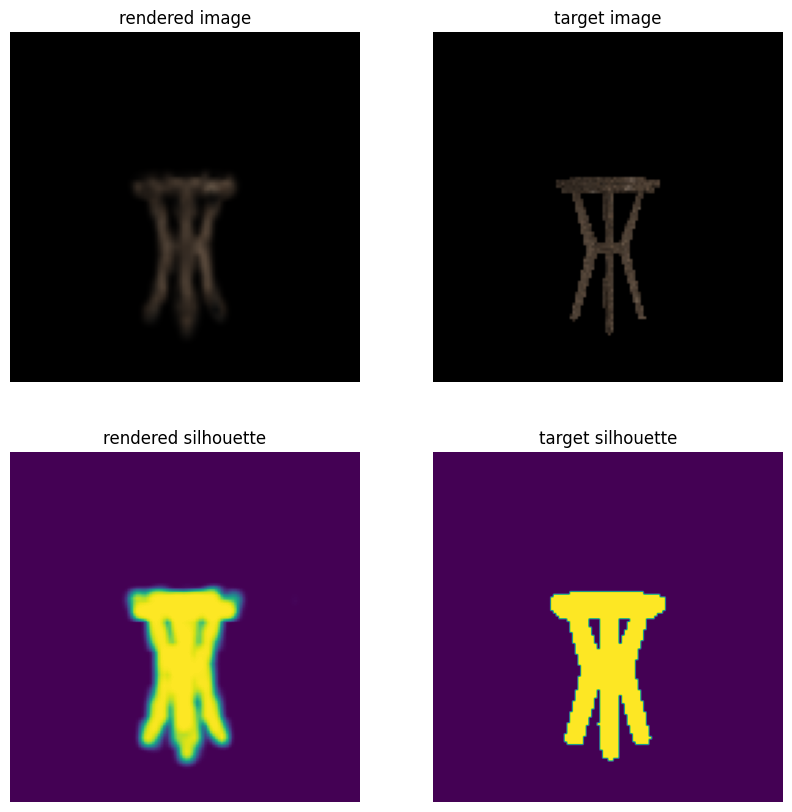

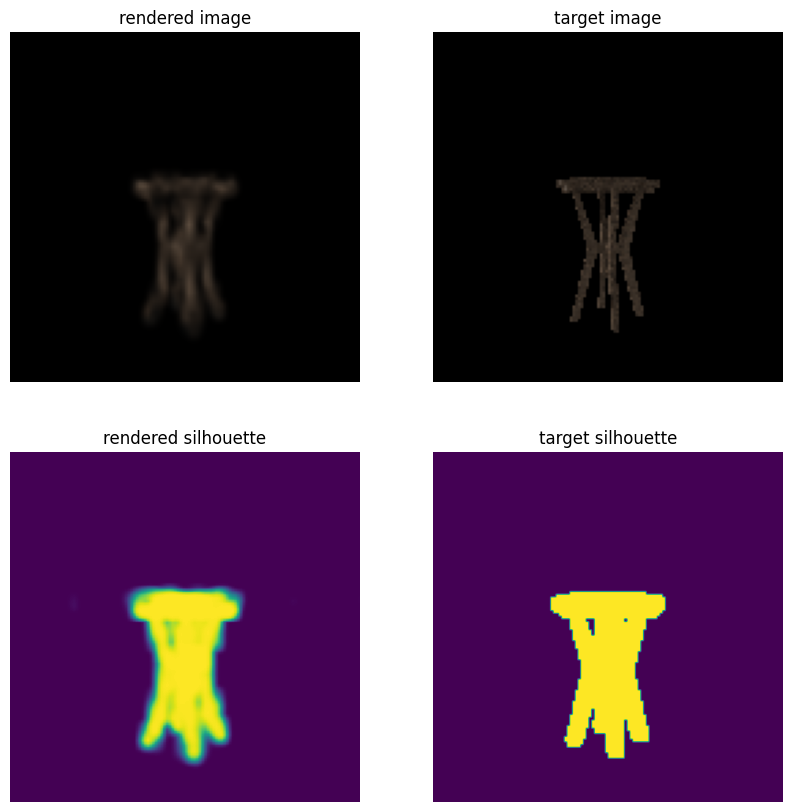

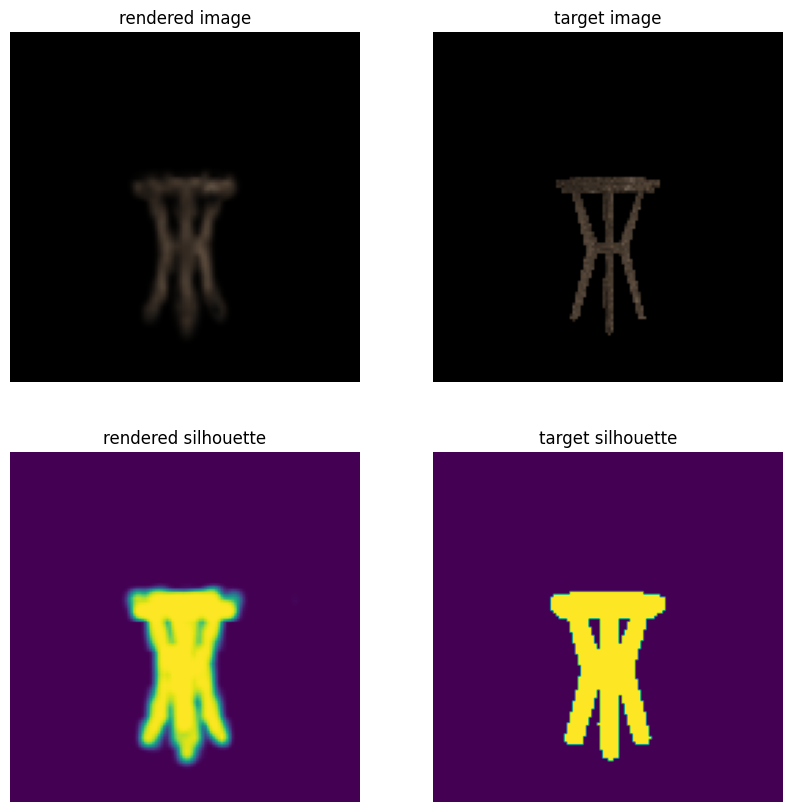

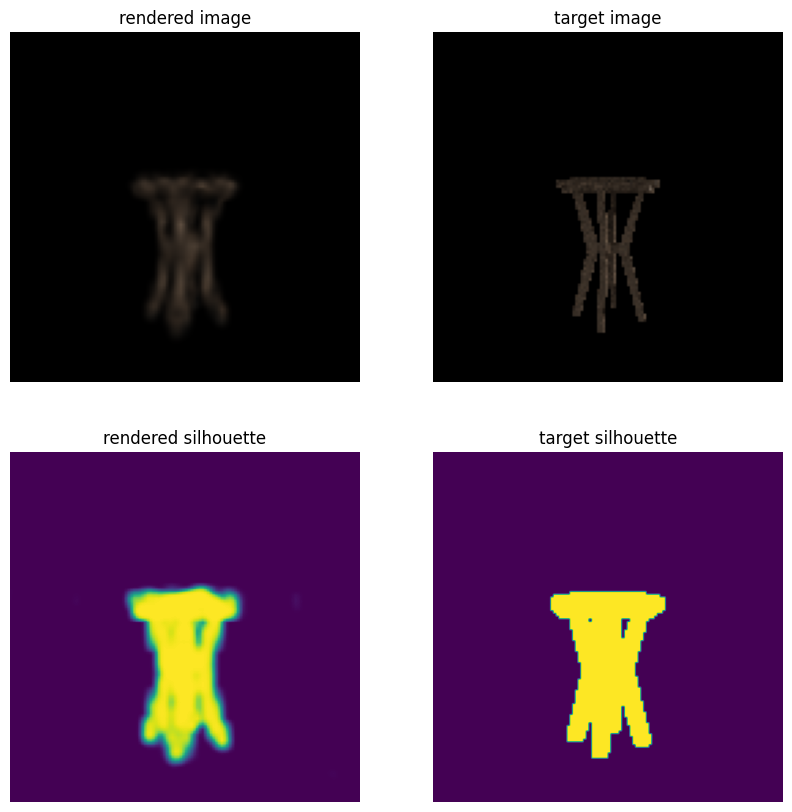

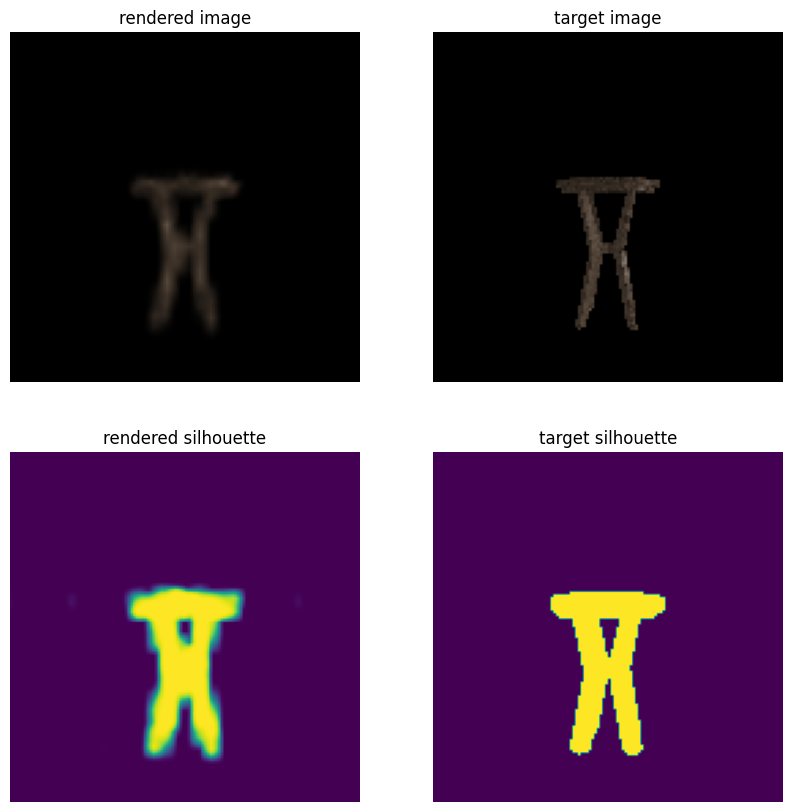

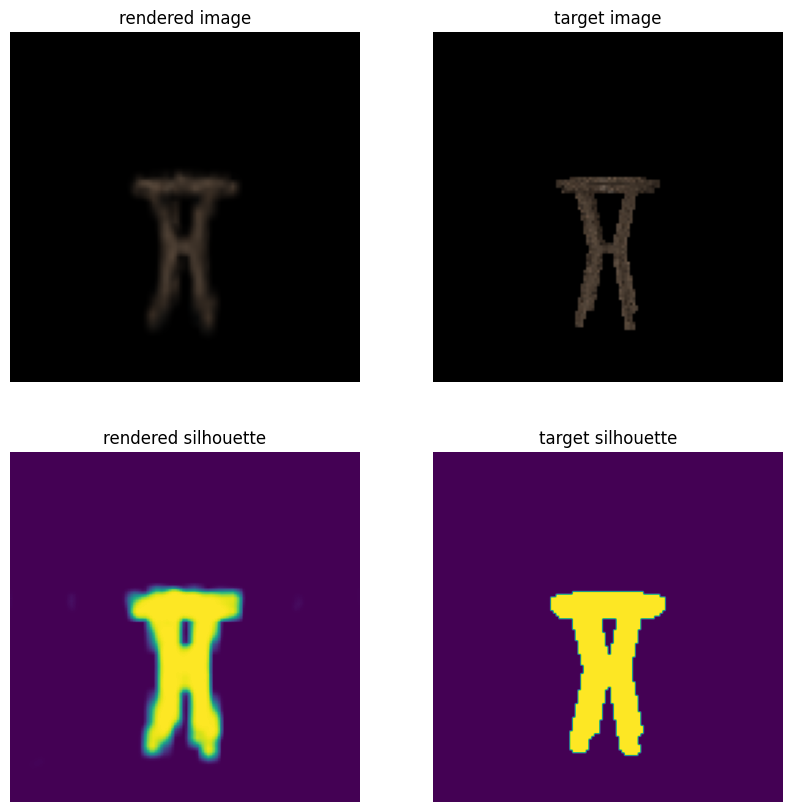

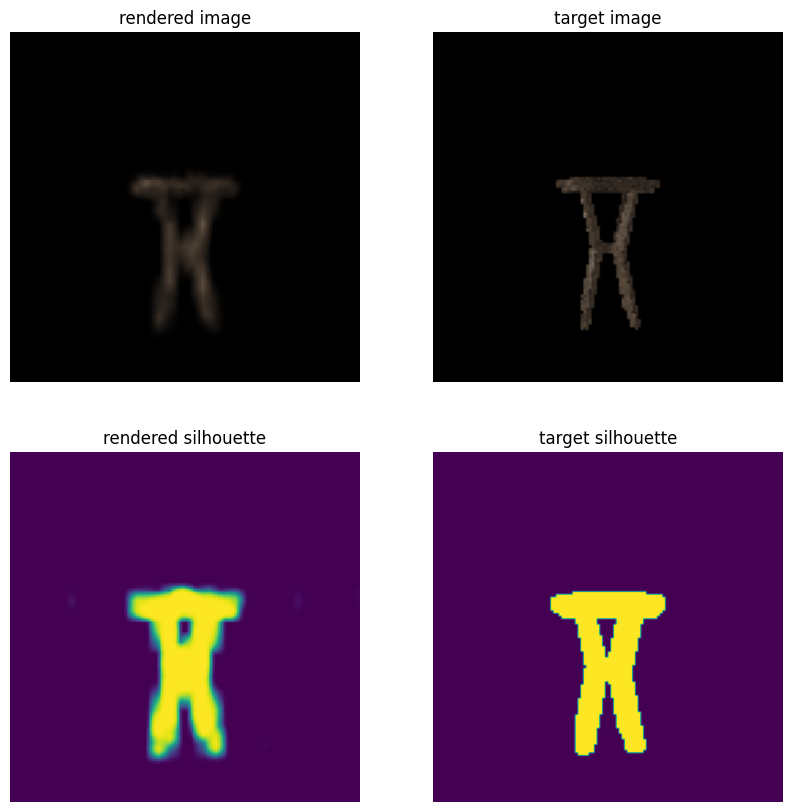

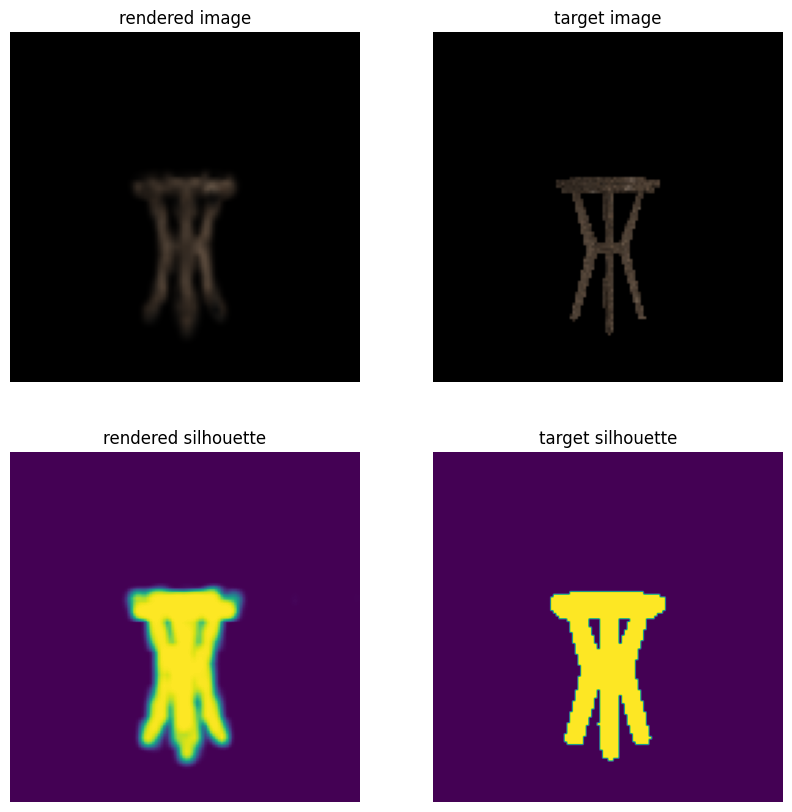

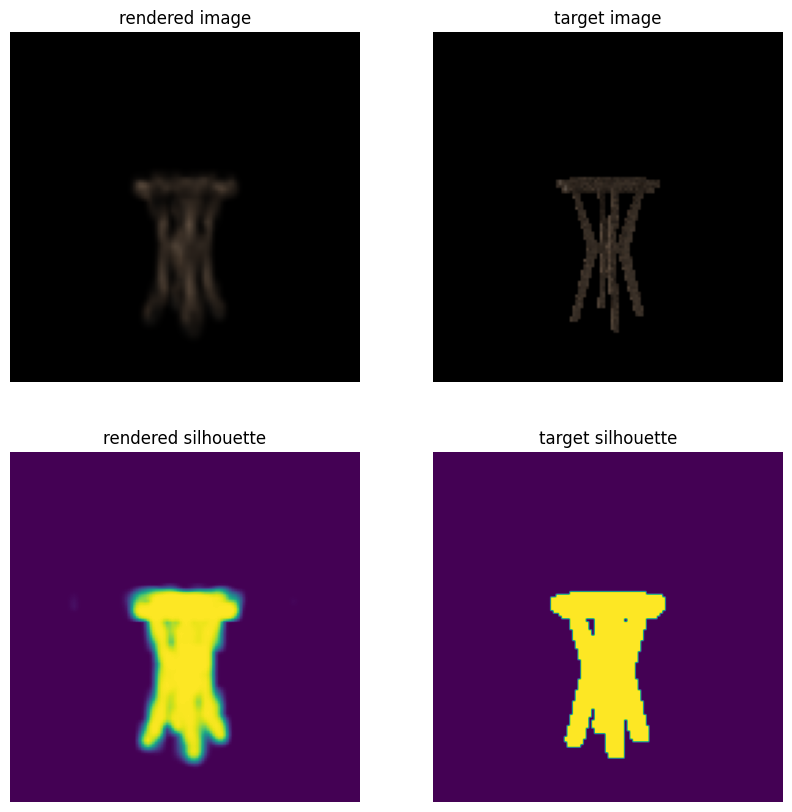

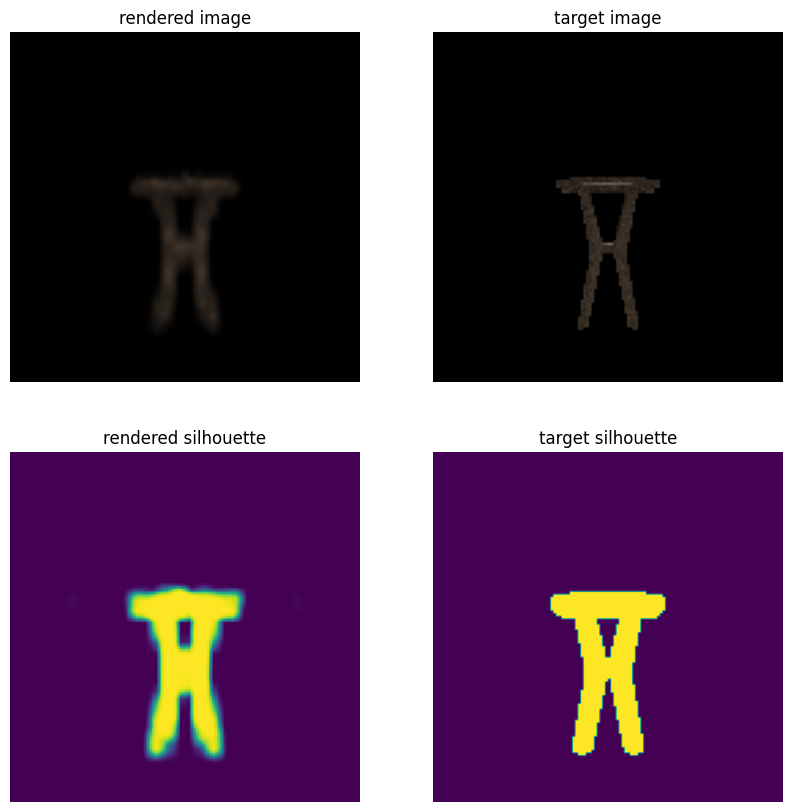

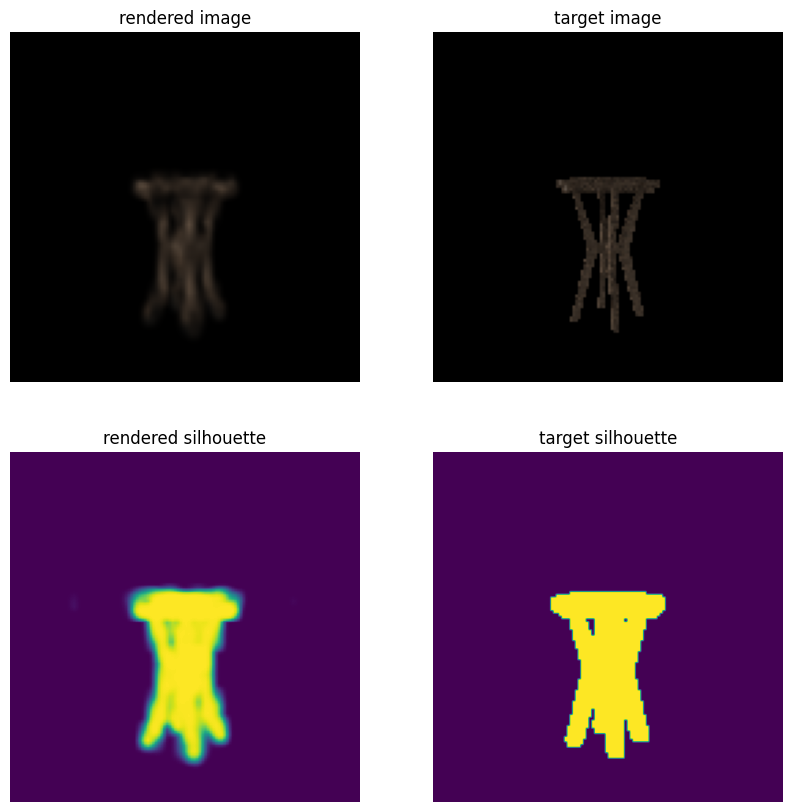

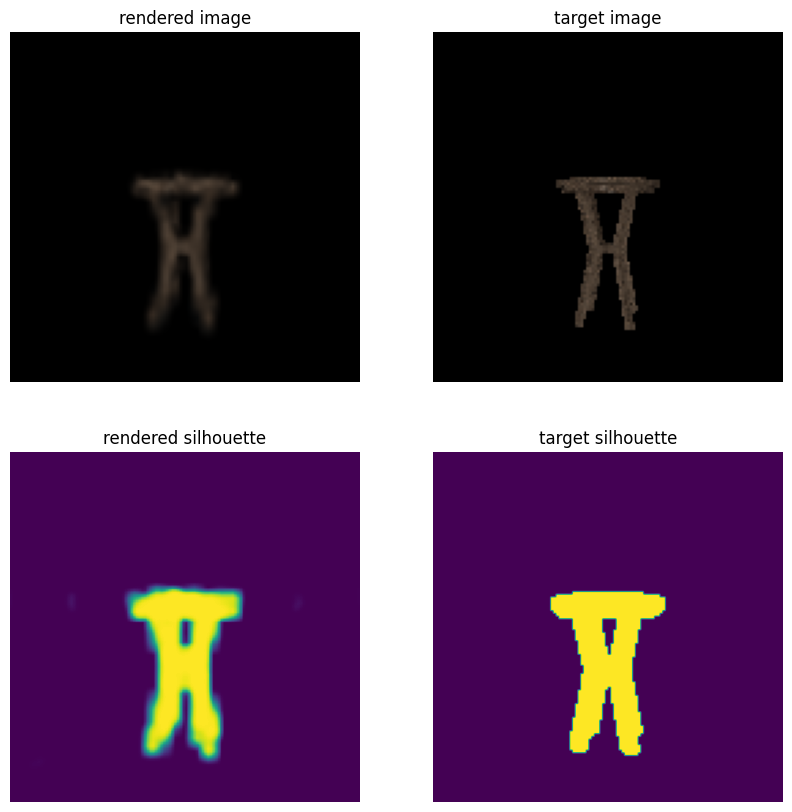

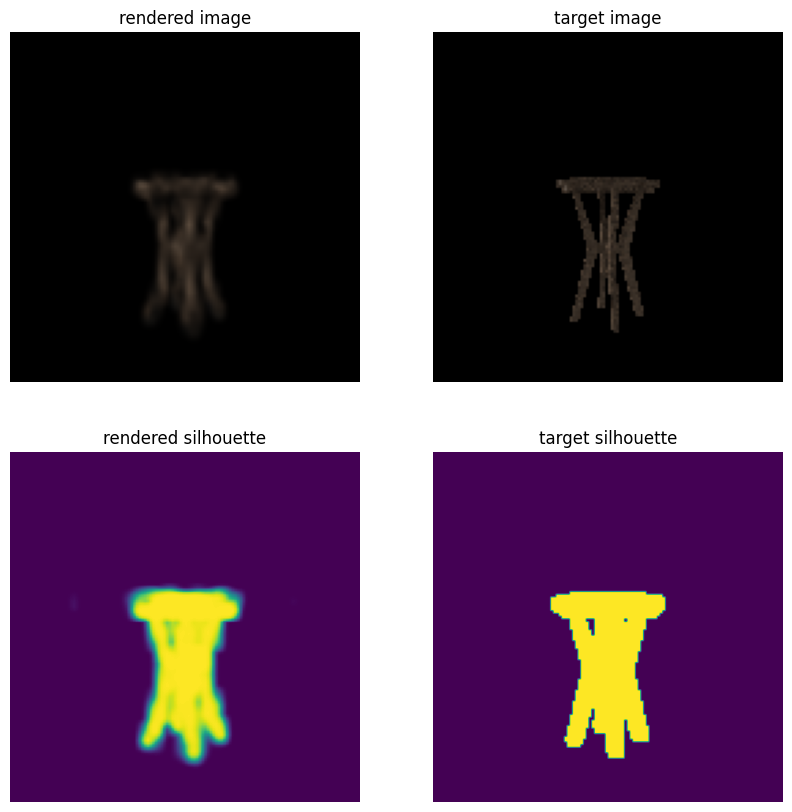

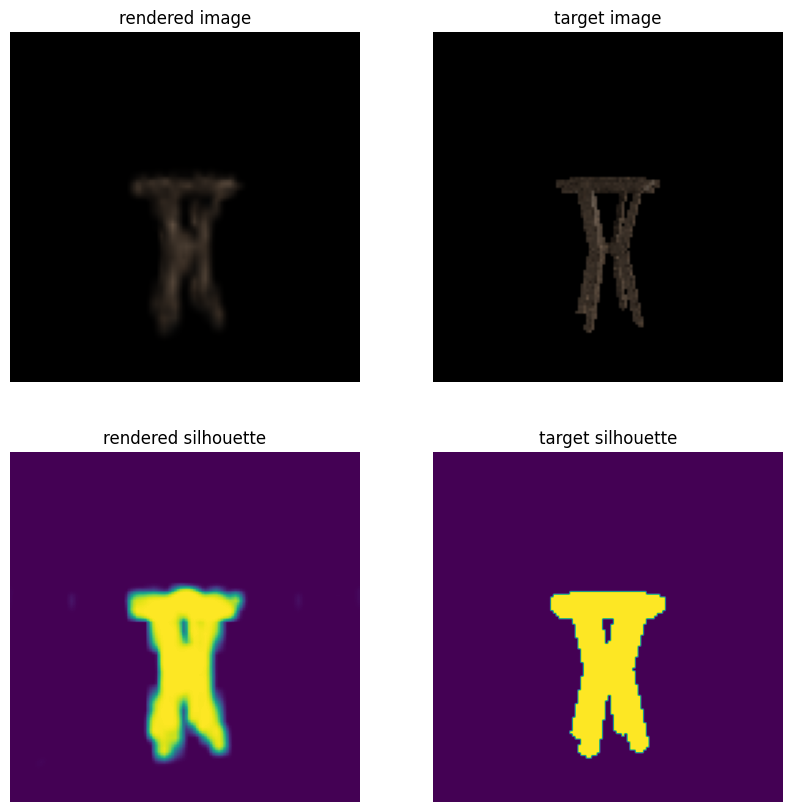

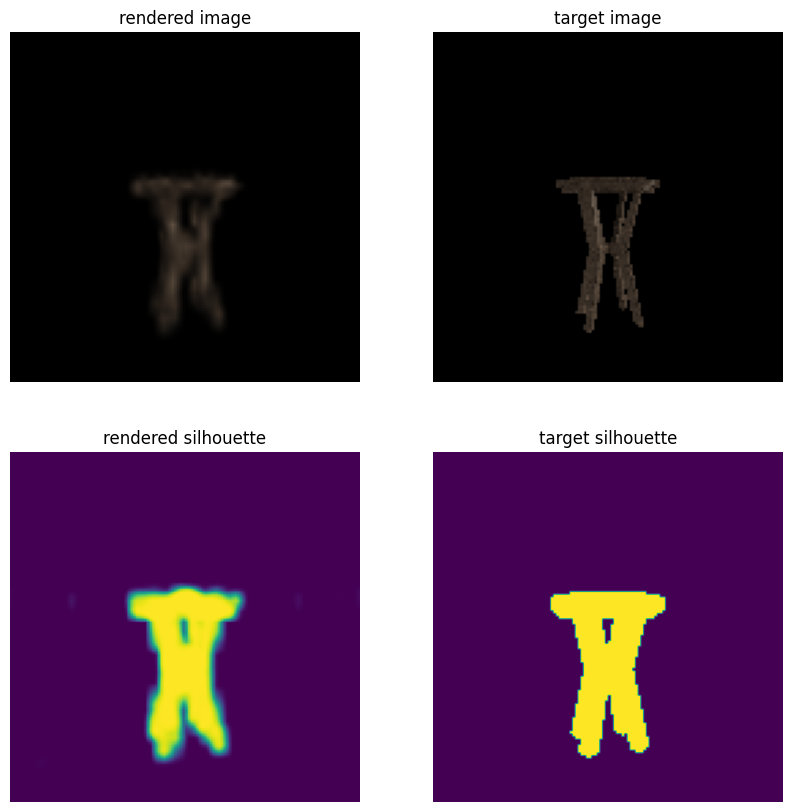

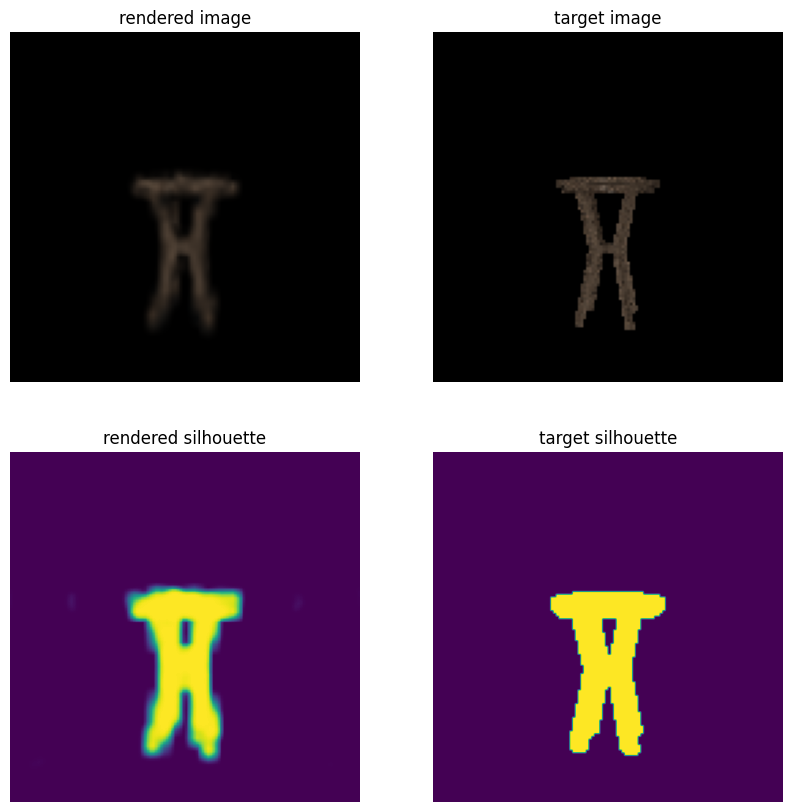

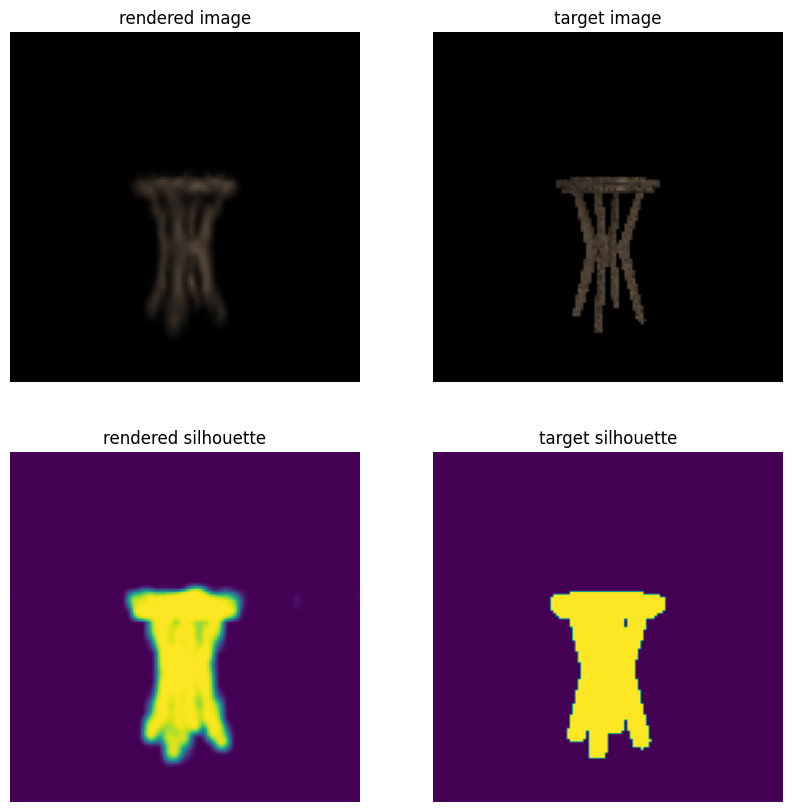

In [91]:
# First move all relevant variables to the correct device.
target_cameras = target_cameras.to(device)
target_images = target_images.to(device)
target_silhouettes = target_silhouettes.to(device)

color_loss_history = []
sil_loss_history = []
fea_loss_history = []

# Instantiate the volumetric model.
# We use a cubical volume with the size of 
# one side = 128. The size of each voxel of the volume 
# is set to volume_extent_world / volume_size s.t. the
# volume represents the space enclosed in a 3D bounding box
# centered at (0, 0, 0) with the size of each side equal to 3.
volume_size = 64
volume_model = VolumeModel(
    renderer,
    volume_size=[volume_size] * 3, 
    voxel_size = volume_extent_world / volume_size,
).to(device)

# Instantiate the Adam optimizer. We set its master learning rate to 0.1.
lr = 0.1
optimizer = torch.optim.Adam(volume_model.parameters(), lr=lr)

# We do 300 Adam iterations and sample 10 random images in each minibatch.
batch_size = 10
n_iter = 1500
for iteration in range(n_iter):

    # In case we reached the last 75% of iterations,
    # decrease the learning rate of the optimizer 10-fold.
    if iteration == round(n_iter * 0.75):
        print('Decreasing LR 10-fold ...')
        optimizer = torch.optim.Adam(
            volume_model.parameters(), lr=lr * 0.1
        )
    
    # Zero the optimizer gradient.
    optimizer.zero_grad()
    
    # Sample random batch indices.
    batch_idx = torch.randperm(len(target_cameras))[:batch_size]
    
    # Sample the minibatch of cameras.
    batch_cameras = FoVPerspectiveCameras(
        R = target_cameras.R[batch_idx], 
        T = target_cameras.T[batch_idx], 
        znear = target_cameras.znear[batch_idx],
        zfar = target_cameras.zfar[batch_idx],
        aspect_ratio = target_cameras.aspect_ratio[batch_idx],
        fov = target_cameras.fov[batch_idx],
        device = device,
    )
    
    # Evaluate the volumetric model.
    rendered_images, rendered_silhouettes = volume_model(
        batch_cameras
    ).split([3, 1], dim=-1)
    
    # Compute the silhouette error as the mean huber
    # loss between the predicted masks and the
    # target silhouettes.
    sil_err = huber(
        rendered_silhouettes[..., 0], target_silhouettes[batch_idx],
    ).abs().mean()

    # Compute the color error as the mean huber
    # loss between the rendered colors and the
    # target ground truth images.
    color_err = huber(
        rendered_images, target_images[batch_idx],
    ).abs().mean()


    FEA_err=evaluateFEA(FEA,volume_model)
    
    if(first_value_bool == False):
        first_value = FEA_err
    
    # The optimization loss is a simple
    # sum of the color and silhouette errors.
    loss = color_err + sil_err + FEA_err / first_value
    color_loss_history.append(color_err.item())
    sil_loss_history.append(sil_err.item())
    fea_loss_history.append(FEA_err.item())
    
    # Print the current values of the losses.
    if iteration % 5 == 0:
        print(
            f'Iteration {iteration:05d}:'
            + f' color_err = {float(color_err):1.2e}'
            + f' mask_err = {float(sil_err):1.2e}'
            + f' FEA_err = {float(FEA_err):1.2e}'
        )
    
    # Take the optimization step.
    loss.backward()
    optimizer.step()
    
    # Visualize the renders every 40 iterations.
    if iteration % 20 == 0:
        # Visualize only a single randomly selected element of the batch.
        im_show_idx = int(torch.randint(low=0, high=batch_size, size=(1,)))
        fig, ax = plt.subplots(2, 2, figsize=(10, 10))
        ax = ax.ravel()
        clamp_and_detach = lambda x: x.clamp(0.0, 1.0).cpu().detach().numpy()
        ax[0].imshow(clamp_and_detach(rendered_images[im_show_idx]))
        ax[1].imshow(clamp_and_detach(target_images[batch_idx[im_show_idx], ..., :3]))
        ax[2].imshow(clamp_and_detach(rendered_silhouettes[im_show_idx, ..., 0]))
        ax[3].imshow(clamp_and_detach(target_silhouettes[batch_idx[im_show_idx]]))
        for ax_, title_ in zip(
            ax, 
            ("rendered image", "target image", "rendered silhouette", "target silhouette")
        ):
            ax_.grid("off")
            ax_.axis("off")
            ax_.set_title(title_)
        fig.canvas.draw(); fig.show()
        display.clear_output(wait=True)
        display.display(fig)

## 6. Visualizing the optimized volume



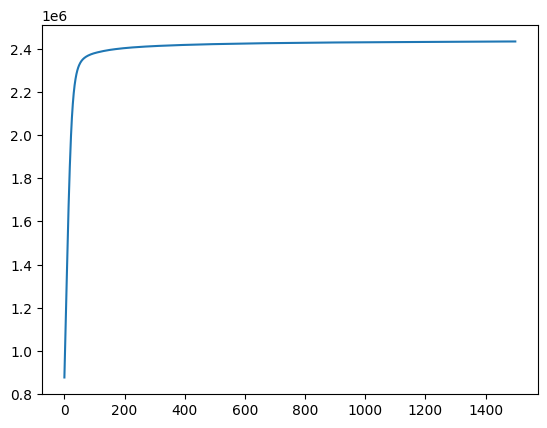

In [92]:
plt.plot(fea_loss_history)



Finally, we visualize the optimized volume by rendering from multiple viewpoints that rotate around the volume's y-axis.

Generating rotating volume ...


  0%|          | 0/28 [00:00<?, ?it/s]

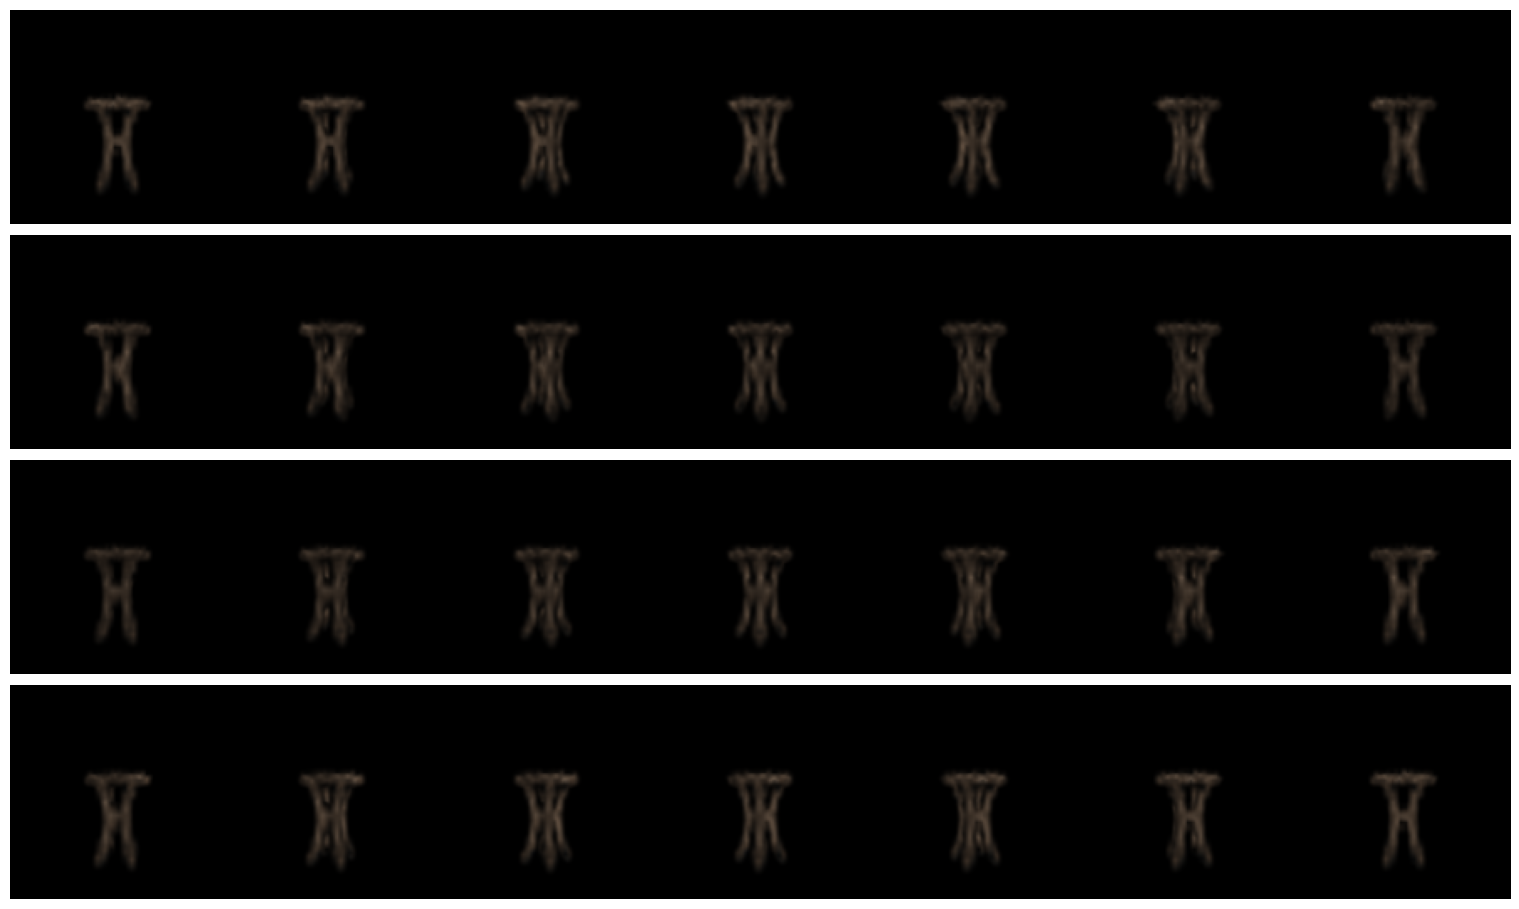

In [93]:
def generate_rotating_volume(volume_model, n_frames = 50):
    logRs = torch.zeros(n_frames, 3, device=device)
    logRs[:, 1] = torch.linspace(0.0, 2.0 * 3.14, n_frames, device=device)
    Rs = so3_exp_map(logRs)
    Ts = torch.zeros(n_frames, 3, device=device)
    Ts[:, 2] = 2.7
    frames = []
    print('Generating rotating volume ...')
    for R, T in zip(tqdm(Rs), Ts):
        camera = FoVPerspectiveCameras(
            R=R[None], 
            T=T[None], 
            znear = target_cameras.znear[0],
            zfar = target_cameras.zfar[0],
            aspect_ratio = target_cameras.aspect_ratio[0],
            fov = target_cameras.fov[0],
            device=device,
        )
        frames.append(volume_model(camera)[..., :3].clamp(0.0, 1.0))
    return torch.cat(frames)
    
with torch.no_grad():
    rotating_volume_frames = generate_rotating_volume(volume_model, n_frames=7*4)

image_grid(rotating_volume_frames.clamp(0., 1.).cpu().numpy(), rows=4, cols=7, rgb=True, fill=True)
plt.show()

## 7. Visualize Density Field

In [94]:
densities = torch.sigmoid(volume_model.log_densities)
colors = torch.sigmoid(volume_model.log_colors).cpu().detach().numpy()

densities=densities.unsqueeze(axis=0)
print(densities.shape)
scaleDown=2
down=torch.nn.Upsample(size=(densities.shape[2]//scaleDown, 
                                  densities.shape[3]//scaleDown, 
                                  densities.shape[4]//scaleDown))
densities=down(densities)
densities=densities.squeeze(axis=0).cpu().detach().numpy()
# densities = volume_model.log_densities.cpu().detach().numpy()
# colors = volume_model.log_colors.cpu().detach().numpy()
# plt.imshow(densities[0,64,:,:], cmap='Greys', interpolation='nearest')
# plt.show()
# plt.imshow(densities[0,:,64,:], cmap='Greys', interpolation='nearest')
# plt.show()
# plt.imshow(densities[0,:,:,64], cmap='Greys', interpolation='nearest')
# plt.show()

# N=8
# image_grid(densities.T, rows=int(N), cols=int(128/N), rgb=True, fill=True)
print(densities.shape)
r=10
minn=densities.shape[1]//2-r
maxx=densities.shape[1]//2+r
r1=5
minn1=densities.shape[1]//2-r1
maxx1=densities.shape[1]//2+r1
D=densities[0,minn1:maxx1,minn:maxx,minn1:maxx1]
print(D.shape)
# D=densities[0,...]
plotFieldOnMesh( np.swapaxes(densities[0,...],1,2))
plotFieldOnMesh( np.swapaxes(D,1,2))

torch.Size([1, 1, 64, 64, 64])
(1, 32, 32, 32)
(10, 20, 10)


## Export Model

In [95]:
from skimage import measure

In [96]:
this_model = np.swapaxes(densities[0,...],1,2)
nelz,nelx,nely=this_model.shape
iso=0.1

lighting_effects = dict(ambient=0.4, diffuse=0.9, roughness = 0.9, specular=1.0, fresnel=0.2)
vol=np.zeros((2+nelz,2+nelx,2+nely))
vol[1:-1,1:-1,1:-1]=this_model.reshape((nelz,nelx,nely))
verts, faces, normals, values = measure.marching_cubes(vol, iso)


In [97]:
import pymeshlab
ms = pymeshlab.MeshSet()

In [98]:
ms.add_mesh(pymeshlab.Mesh(vertex_matrix=verts, face_matrix=faces, v_normals_matrix=normals))

In [99]:
ms.save_current_mesh('./chair_fea_v64_normalized_FEA_lr_01.obj')

In [41]:
densities[0].max()

0.9980988

In [43]:
colors.shape

(3, 128, 128, 128)

In [17]:
import gc

# volume_model.cpu()
# del volume_model
gc.collect()
torch.cuda.empty_cache()